# 0.0 Imports

## 0.1 Libraries

In [2]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import datetime
import warnings
from tabulate import tabulate
# from boruta import BorutaPy
# import pickle
# from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
# from sklearn.model_selection import TimeSeriesSplit, cross_val_score
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression, Lasso
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
# from category_encoders import TargetEncoder
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.compose import TransformedTargetRegressor

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 0.2 Data

In [3]:
dados_sales = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/train.csv',low_memory=False)
dados_stores = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/store.csv')
dados = pd.merge(dados_sales,dados_stores,how='left',on='Store')
dados = dados.sample(int(round(dados.shape[0]/2,0)),random_state=101) # more data this time
dados.reset_index(drop=True,inplace=True)
dados.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,965,7,2014-11-02,0,0,0,0,0,0,a,c,110.0,NaN,NaN,0,NaN,NaN,NaN
1,268,1,2013-12-30,6995,814,1,0,0,1,a,a,4520.0,2.0,2014.0,0,NaN,NaN,NaN
2,1112,6,2015-03-28,8671,774,1,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
3,128,1,2014-07-21,6675,534,1,0,0,0,d,c,2000.0,NaN,NaN,1,1.0,2013.0,"Jan,Apr,Jul,Oct"
4,687,4,2015-06-11,6961,675,1,0,0,0,d,c,2770.0,NaN,NaN,0,NaN,NaN,NaN


## Export Data

In [4]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/inital_data2.csv',index=False)

# 1.0 Data Description and Cleaning

## Import Data

In [132]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/inital_data2.csv')

## 1.1 Rename Columns and Values

In [117]:
# CamelCase to snake_case
for c in range(len(dados.columns)):
    dados.rename(columns={dados.columns.values[c]:inflection.underscore(dados.columns.values[c])},inplace=True)

In [33]:
dados['state_holiday'] = dados['state_holiday'].map({'a':'public holiday', 'b':'Easter holiday', 'c':'Christmas', '0':'None'})
dados['assortment'] = dados['assortment'].map({'a':'basic','b':'extra','c':'extended'})

## 1.2 Data Dimension

In [34]:
print(f'Rows: {dados.shape[0]}\nColumns: {dados.shape[1]}')

Rows: 508604
Columns: 18


## 1.3 Missing Data

### 1.3.1 Check

In [36]:
dados.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              1340
competition_open_since_month    161737
competition_open_since_year     161737
promo2                               0
promo2_since_week               254124
promo2_since_year               254124
promo_interval                  254124
dtype: int64

### 1.3.2 Handling with

In [37]:
# I suppose that the competition_distance == nan refers that there's no competition!
# Lets'se if it's true

dados[dados['competition_distance'].isna()].isna().sum()

store                              0
day_of_week                        0
date                               0
sales                              0
customers                          0
open                               0
promo                              0
state_holiday                      0
school_holiday                     0
store_type                         0
assortment                         0
competition_distance            1340
competition_open_since_month    1340
competition_open_since_year     1340
promo2                             0
promo2_since_week                937
promo2_since_year                937
promo_interval                   937
dtype: int64

Yeah, thats true, this data probably is missing at random (MAR), then we can input it with some arbitrary value.

All of the empty distances have empty competition_open_since.. what confirm that the competition has never been started! 

In [38]:
# Vou usar um valor arbitrário que significará que a competição nunca abriu!

for index in dados[dados['competition_distance'].isna()].index:
    dados.loc[index,'competition_distance'] = 999999 # High values suggests that the competitors are so far that there's no competition
    dados.loc[index,'competition_open_since_month'] = -1 # It suggets that it has never been opened
    dados.loc[index,'competition_open_since_year'] = -1 # It suggets that it has never been opened

In [39]:
# Ver quantos restaram
dados.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    160397
competition_open_since_year     160397
promo2                               0
promo2_since_week               254124
promo2_since_year               254124
promo_interval                  254124
dtype: int64

In [40]:
# I suppose that if there's no year since competition started, there's no month and vice-versa (there's no date record)
# Let's se if it's true

dados[dados['competition_open_since_month'].isna()].isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    160397
competition_open_since_year     160397
promo2                               0
promo2_since_week                68367
promo2_since_year                68367
promo_interval                   68367
dtype: int64

Era isso mesmo!

In [41]:
# Vamos ver se a loja que tem competition date nulo em um record tem, em outro record, competition date não nulo
# caso a intersecção seja vazia, significa que a todos os records dessas lojas sem competition date são nulos
# isso pode nos indicar que essas lojas provavelmente não documentaram desde quando começou a competition

lojas_com_competition_date = dados[~dados['competition_open_since_month'].isna()]['store'].unique()
lojas_sem_competition_date = dados[dados['competition_open_since_month'].isna()]['store'].unique()

np.intersect1d(lojas_com_competition_date,lojas_sem_competition_date)

array([], dtype=int64)

Realmente era o que eu estava pensando, dessa forma, as competition dates não foram documentadas por algum motivo: seja por nunca informaram à base de dados, ou não conseguiram chegar à data, ou a loja foi implementada depois do concorrente, em problema real seria interessante tentar entender afundo o motivo disso, pois assim poderíamos diagnosticar o tipo de missing data e escolher a técnica mais efetiva para solucionar o problema!

In [42]:
# Dessa forma, o tipo de missing data é de difícil diagnóstico, e para não perder muitos records
# vou imputar um valor arbitrário também!

for index in dados[dados['competition_open_since_month'].isna()].index:
    dados.loc[index,'competition_open_since_month'] = 999999 
    dados.loc[index,'competition_open_since_year'] = 999999 

In [44]:
# Ver quantos restaram
dados.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               254124
promo2_since_year               254124
promo_interval                  254124
dtype: int64

In [45]:
# I wanna check if the NaN in these columns are just when promo2 is 0 (no promo2) what would be very logic.
# Because if there's no promo2, theres no since date or interval

(dados[dados['promo2']==0].isna()).sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               254124
promo2_since_year               254124
promo_interval                  254124
dtype: int64

So true! 

Every NaN in the last 3 columns is because promo2 has never been started!

In [46]:
for index in dados[dados['promo2_since_week'].isna()].index:
    dados.loc[index, 'promo2_since_week'] = -1 # It suggets that there's no promo2 start
    dados.loc[index, 'promo2_since_year'] = -1 # It suggets that there's no promo2 start
    dados.loc[index, 'promo_interval'] = 'No promo2' # It suggets that there's no promo2 start

### 1.3.3 Final Check

In [48]:
dados.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

All done.

## 1.4 Data Types

### 1.4.1 Check

In [49]:
dados.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

### 1.4.2 Change

In [50]:
# date to datetime64 and int to float
dados['date'] = pd.to_datetime(dados['date'])
dados['competition_open_since_month'] = dados['competition_open_since_month'].astype(int)
dados['competition_open_since_year'] = dados['competition_open_since_year'].astype(int)
dados['promo2_since_week'] = dados['promo2_since_week'].astype(int)
dados['promo2_since_year'] = dados['promo2_since_year'].astype(int)

### 1.4.3 Final Check

In [51]:
dados.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

All done.

## 1.5 Descriptive Statistics

### 1.5.1 Numeric Variables Analysis

In [61]:
df_aux = dados[['store','sales','customers','competition_distance','competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year']]

num_kurt = df_aux.apply(lambda x: x.kurtosis()) # Add kurtosis
num_skewness = df_aux.apply(lambda x: x.skew()) # Add skewness
num_range = df_aux.apply(lambda x: x.max() - x.min()) # Add range
pd.concat([df_aux.describe().T,num_kurt,num_skewness,num_range],axis=1).rename(columns={0:'kurtosis',1:'skewness',2:'range'}).drop('count',1)

,mean,std,min,25%,50%,75%,max,kurtosis,skewness,range
store,558.521199,321.876947,1.0,280.0,558.0,837.0,1115.0,-1.199360,-0.001800,1114.0
sales,5772.169863,3855.057633,0.0,3724.0,5740.0,7852.0,41551.0,1.846384,0.653961,41551.0
customers,632.951320,465.456060,0.0,404.0,609.0,836.0,5494.0,7.152674,1.615475,5494.0
competition_distance,8049.123542,51560.743037,20.0,710.0,2330.0,6910.0,999999.0,357.928221,18.766489,999979.0
competition_open_since_month,315371.770515,464658.586555,-1.0,6.0,10.0,999999.0,999999.0,-1.368458,0.794700,1000000.0
competition_open_since_year,316736.770432,463732.168400,-1.0,2008.0,2012.0,999999.0,999999.0,-1.368458,0.794700,1000000.0
promo2_since_week,11.152162,15.714188,-1.0,-1.0,1.0,22.0,50.0,-0.557693,0.970053,51.0
promo2_since_year,1006.077951,1006.374965,-1.0,-1.0,2009.0,2012.0,2015.0,-2.000000,-0.001396,2016.0


Nothing strange.

The only strange values that we see were the ones that we chose arbitraly to substitute.

### 1.5.2 Categorical Variables Analysis

In [64]:
df_aux = dados.drop(['store','sales','customers','competition_distance','competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year','date'],1)

for column in df_aux:
    print(column.upper()+':')
    print(round(df_aux[column].value_counts(normalize=True)*100,2))
    print('')

DAY_OF_WEEK:
4    14.35
2    14.32
3    14.30
6    14.28
5    14.27
7    14.26
1    14.22
Name: day_of_week, dtype: float64

OPEN:
1    82.99
0    17.01
Name: open, dtype: float64

PROMO:
0    61.86
1    38.14
Name: promo, dtype: float64

STATE_HOLIDAY:
None              96.98
public holiday     1.97
Easter holiday     0.65
Christmas          0.41
Name: state_holiday, dtype: float64

SCHOOL_HOLIDAY:
0    82.18
1    17.82
Name: school_holiday, dtype: float64

STORE_TYPE:
a    54.22
d    30.78
c    13.43
b     1.57
Name: store_type, dtype: float64

ASSORTMENT:
basic       52.79
extended    46.38
extra        0.83
Name: assortment, dtype: float64

PROMO2:
1    50.03
0    49.97
Name: promo2, dtype: float64

PROMO_INTERVAL:
No promo2           49.97
Jan,Apr,Jul,Oct     28.83
Feb,May,Aug,Nov     11.65
Mar,Jun,Sept,Dec     9.56
Name: promo_interval, dtype: float64



Everything looks nice. Nothing strange or considerable outliers.

## 1.6 Columns and Values Filtering

In [118]:
# Let's filter what is useful and useless for our prediction based on the business problem

dados = dados[dados['open']==1] # We want to predict sales when the store is open. When it's closed, sales == 0
dados.drop('open',axis=1,inplace=True) # This column would be constant == 1, useless for our prediction

In [ ]:
# I also need to drop customers, because i cant say how many customers i will have in the store tomorrow
# I would need to make another model to predict it, so i cannot use this column as an input

# Apesar disso, a gente pode usar essa coluna 'customers' para retirar alguns insights legais ou algo a mais!
# Então vou fazer feature engineering com essa coluna, usar na EDA e depois dropar!

## Exporting Dataset (After Data Cleaning)

In [127]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_cleaned2.csv',index=False)

# 2.0 Feature Engineering and Exploratory Data Analysis

## Import Data

In [154]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_cleaned2.csv')

## 2.1 Feature Engineering

Ao invés de ir criando features ao longo da EDA, prefiro criar esse tópico onde coloco todas elas juntas!

Mantendo, assim, o código organizado e limpo!

In [24]:
# Day, Month, Week and Year Variables
dados['day'] = pd.to_datetime(dados['date']).dt.day
dados['month'] = pd.to_datetime(dados['date']).dt.month
dados['year'] = pd.to_datetime(dados['date']).dt.year
dados['week'] = pd.to_datetime(dados['date']).dt.week

In [25]:
# Semester and Quarter
dados['quarter'] = pd.to_datetime(dados['date']).dt.quarter
dados['semester'] = pd.to_datetime(dados['date']).dt.quarter.apply(lambda x: 1 if x == 1 or x == 2 else 2)

In [26]:
# Season
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

dados['season'] = pd.to_datetime(dados['date']).map(season_of_date)

In [27]:
# Weeks for timeseries analyses
dados['week_bin'] = np.nan
for index in range(dados.shape[0]):
    if dados.loc[index,'year']==2013:
        dados.loc[index,'week_bin'] = dados.loc[index,'week']
    if dados.loc[index,'year']==2014:
        dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 52
    if dados.loc[index,'year']==2015:
        dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 104
dados['week_bin'] = dados['week_bin'].astype('int')

In [28]:
# Competition Lifetime
dados['competition_lifetime'] = np.nan
for index in range(dados.shape[0]):
    try:
        data = datetime.datetime(dados.loc[index,'competition_open_since_year'],dados.loc[index,'competition_open_since_month'],1)
        dados.loc[index, 'competition_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - data).days
        
    except:
        dados.loc[index,'competition_lifetime'] = -999 # Never opened
dados['competition_lifetime'] = dados['competition_lifetime'].astype('int')

In [29]:
# Competition
dados['competition'] = dados['competition_lifetime'].apply(lambda x: 0 if x<0 else 1) 

# Negative values suggests that this competition has never been started yet or we don't even have competitors (we chose -999 above)

In [30]:
# Promo2 Lifetime
dados['promo2_lifetime'] = np.nan
for index in range(dados.shape[0]):
    if dados.loc[index,'promo_interval'] != 'No promo2':
        year = dados.loc[index,'promo2_since_year']
        week = dados.loc[index,'promo2_since_week']
        date = "{}-W{}".format(year,week)
        date_datetime = datetime.datetime.strptime(date + '-1', "%Y-W%W-%w")
        dados.loc[index,'promo2_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - date_datetime).days
    else:
        dados.loc[index,'promo2_lifetime'] = -999
dados['promo2_lifetime'] = dados['promo2_lifetime'].astype(int)

In [31]:
# Promo Count per Week
dados['promo_count_per_week'] = np.nan
for index in range(dados.shape[0]):
    week = dados.loc[index,'week_bin']
    store = dados.loc[index,'store']
    try:
        dados.loc[index,'promo_count_per_week'] = dados[dados['store']==store].groupby('week_bin').sum()['promo'][week]
    except:
        dados.loc[index,'promo_count_per_week'] = 0
dados['promo_count_per_week'] = dados['promo_count_per_week'].astype('int')

In [32]:
# Enumerate per week each store promotion
dados['promo_n'] = np.nan
for c in range(dados.shape[0]):
    if dados.loc[c,'promo_count_per_week']>0: # os que tem promoção na semana: Enumerate the promotion per store on each week
        week = dados.loc[c,'week_bin']
        store = dados.loc[c,'store']
        df_aux = pd.DataFrame(dados[(dados['store']==store)&(dados['week_bin']==week)].sort_values(by='date')['promo'])[dados['promo']==1].reset_index().reset_index().set_index('index')
        df_aux['level_0'] = df_aux['level_0'] + 1
        for index in df_aux.index:
            dados.loc[index,'promo_n'] = df_aux.loc[index,'level_0']
    elif dados.loc[c,'promo_count_per_week']==0: # os que não tem promoção na semana: iguala a 0
        dados.loc[c,'promo_n'] = 0
dados['promo_n'].fillna(-1,inplace=True) # São dias sem promoção em semanas com promoção: iguala a -1
dados['promo_n'] = dados['promo_n'].astype('int')

In [184]:
# This column is the one that i told that will be great to extract insights for the business
# I'll drop customers after EDA, because we cannot use it as i told before.

# Sales per customer
dados['sales_per_customer'] = dados['sales']/dados['customers']

## Exporting Dataset (After Feature Engineering)

In [82]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_feature_engineering2.csv',index=False)

## Import Data

In [83]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_feature_engineering2.csv')

## 2.2 Univariate Analysis

### 2.2.1 Dependent Variable

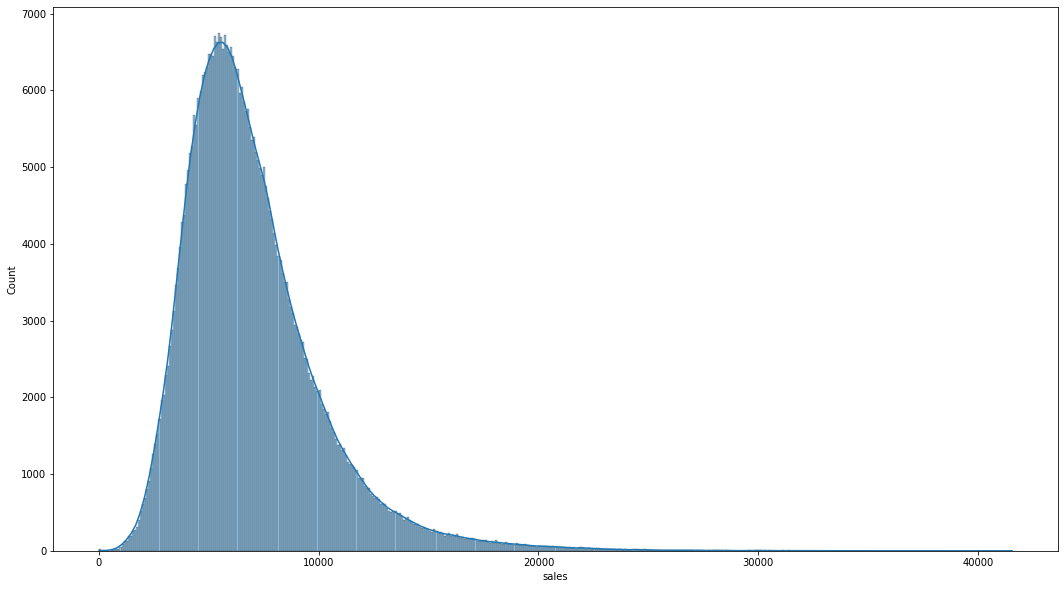

In [43]:
# Distribution Graph

plt.figure(figsize=(18,10))
sns.histplot(dados['sales'],kde=True);

In [44]:
# Descriptive Analysis

desc_dep = pd.DataFrame(dados['sales'].describe()).T
desc_dep['kurtosis'] = dados['sales'].kurtosis() # Add kurtosis
desc_dep['skew'] = dados['sales'].skew() # Add skew
desc_dep['range'] = dados['sales'].max() - dados['sales'].min() # Add range
desc_dep

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew,range
sales,422111.0,6954.921054,3111.385136,0.0,4855.0,6367.0,8359.0,41551.0,4.996137,1.611748,41551


Not a normal distribution, but well distributed.

Mean and Median almost the same (6300-6900 sales). But has skew and kurtosis not equal 3.

It's what i was expecting, positive skewness distribution. (Sales tend to have this behavior)

### 2.2.2 Independent Variables

In [45]:
# Store, Day of Week, State Holiday, School Holiday, Store Type, Assortment, Customers and Sales Per Customer

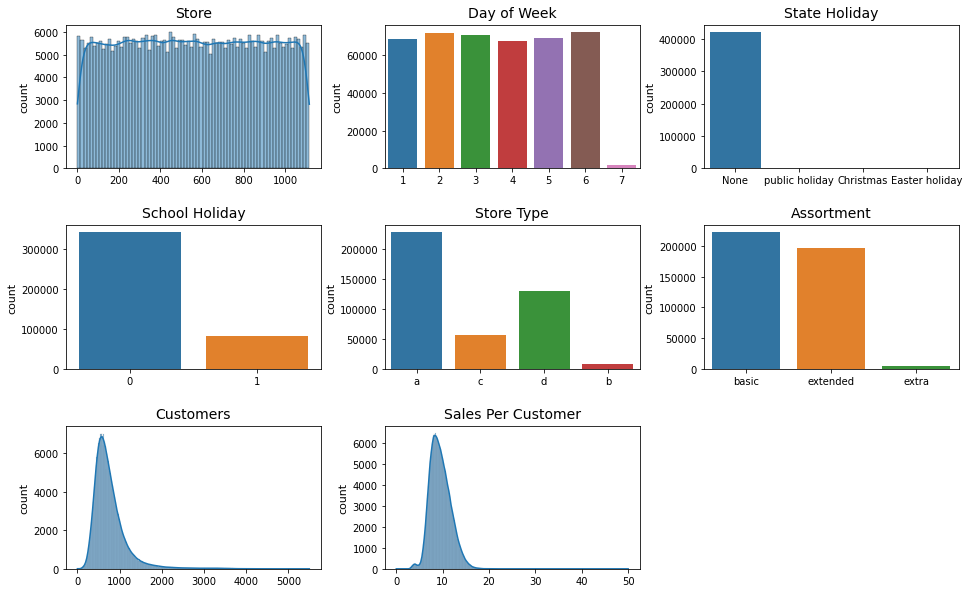

In [232]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.4,wspace=0.25)

plt.subplot(3,3,1)
ax = sns.histplot(dados['store'],kde=True)
ax.set_title('Store',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,2)
ax = sns.countplot(dados['day_of_week'])
ax.set_title('Day of Week',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,3)
ax = sns.countplot(dados['state_holiday'])
ax.set_title('State Holiday',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,4)
ax = sns.countplot(dados['school_holiday'])
ax.set_title('School Holiday',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,5)
ax = sns.countplot(dados['store_type'])
ax.set_title('Store Type',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,6)
ax = sns.countplot(dados['assortment'])
ax.set_title('Assortment',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,7)
ax = sns.histplot(dados['customers'],kde=True)
ax.set_title('Customers',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,8)
ax = sns.histplot(dados['sales_per_customer'],kde=True)
ax.set_title('Sales Per Customer',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.show()

What we can observe:

**Store:** We can consider that we have the same representation for all stores

**Day of Week:** In sunday it has way less represantation (Probably because the stores are closed this day)

**State Holiday and School Holiday:** Seems to behave as expected, more normal days and less holidays. 

**Store Type:** There's a visible predominance of some store types.

**Assortment:** more assortment == less representation

**Customers:** The peak of this distribution is less than 1000, but it has a positive skew as expected.

**Sales Per Customer:** We can see that most of the times we have values between 5 and 15, but it can reach around 50, positive skew as expected.

In [47]:
# competition, competition_distance, competition_lifetime, competition_open_since_month and competition_open_since_year

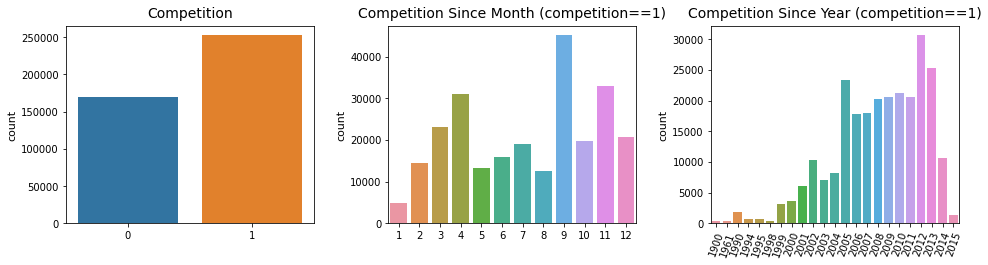

In [48]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
ax = sns.countplot(dados['competition'])
ax.set_title('Competition',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,2)
ax = sns.countplot(dados[dados['competition']==1]['competition_open_since_month'])
ax.set_title('Competition Since Month (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,3)
ax = sns.countplot(dados[dados['competition']==1]['competition_open_since_year'])
ax.set_title('Competition Since Year (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)
plt.tick_params(axis='x',rotation=70)

plt.show()

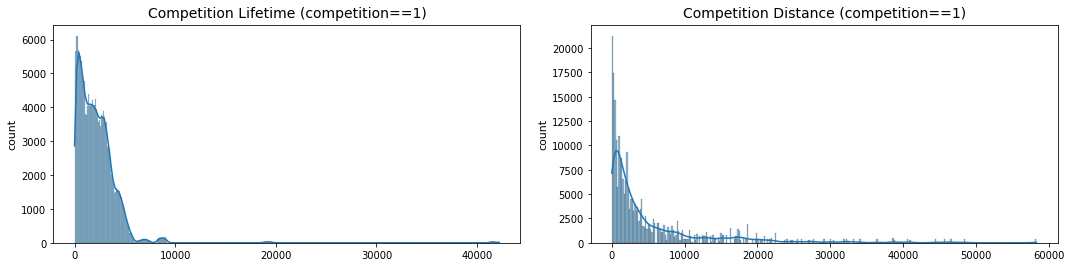

In [49]:
plt.figure(figsize=(18,4))
plt.subplots_adjust(wspace=0.15)
plt.subplot(1,2,1)
ax = sns.histplot(dados[dados['competition']==1]['competition_lifetime'],kde=True)
ax.set_title('Competition Lifetime (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(1,2,2)
ax = sns.histplot(dados[dados['competition']==1]['competition_distance'],kde=True)
ax.set_title('Competition Distance (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.show()

What we can observe:

**Competition:** We can see that almost every records are from stores with competition that already started

**Competition Distance:** Competitors are usually close to the stores, then the distribution has a positive skew

**Competition Lifetime:** The competition is recent in most cases, then the distribution has a positive skew

**Competition Open Since Month:** We have a peak of competition start in september for some reason, which probably is a interesting insight.

**Competition Open Since Year:** Most of the competitors are recent, as we saw in competition lifetime anaylis, since 2005 we more competitors opening.

**RESUMO:** A maioria das lojas tem competidores, geralmente são perto delas e a concorrência geralmente não tem mais de 10 anos. Uma coisa interessante é que setembro tem um pico competition since por algum motivo.

In [10]:
# promo, promo_count_per_week, promo_n, promo2, promo2_since_week, promo2_since_year, promo2_interval, promo2_lifetime

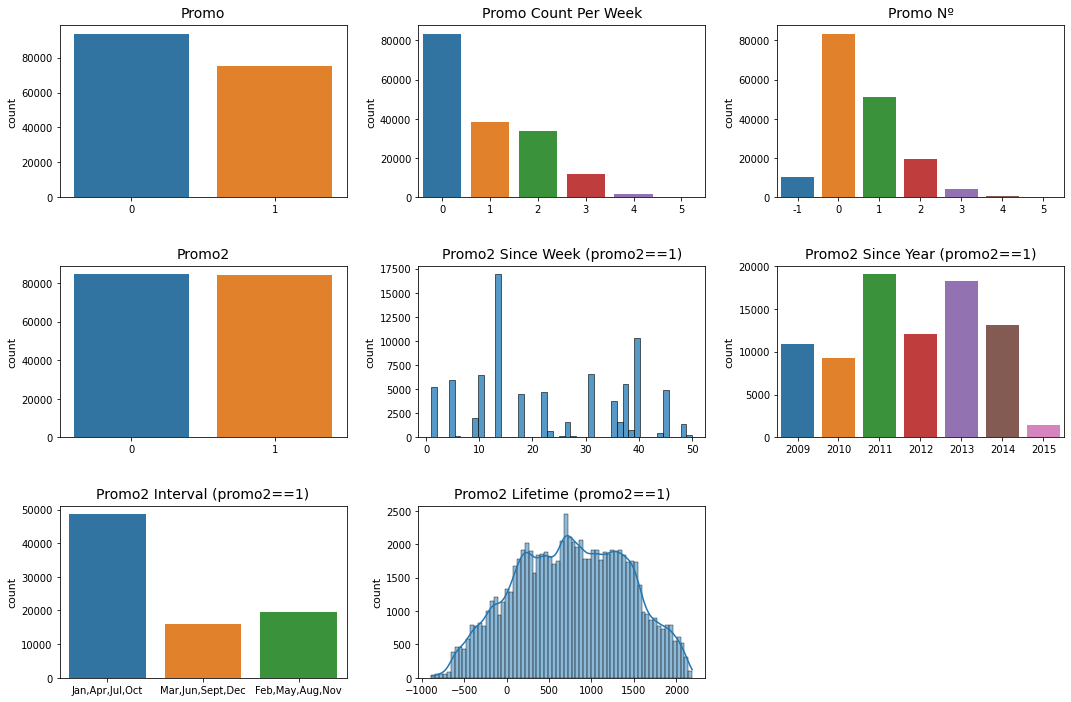

In [11]:
plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace=0.4,wspace=0.25)

plt.subplot(3,3,1)
ax = sns.countplot(dados['promo'])
ax.set_title('Promo',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,2)
ax = sns.countplot(dados['promo_count_per_week'])
ax.set_title('Promo Count Per Week',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,3)
ax = sns.countplot(dados['promo_n'])
ax.set_title('Promo Nº',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,4)
ax = sns.countplot(dados['promo2'])
ax.set_title('Promo2',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,5)
ax = sns.histplot(dados[dados['promo2']==1]['promo2_since_week'])
ax.set_title('Promo2 Since Week (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,6)
ax = sns.countplot(dados[dados['promo2']==1]['promo2_since_year'])
ax.set_title('Promo2 Since Year (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,7)
ax = sns.countplot(dados[dados['promo2']==1]['promo_interval'])
ax.set_title('Promo2 Interval (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,8)
ax = sns.histplot(dados[dados['promo2']==1]['promo2_lifetime'],kde=True)
ax.set_title('Promo2 Lifetime (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)


plt.show()

What we can observe:

**Promo:** There's a huge represantation of promo, which means that almost every day we have promo

**Promo Count Per Week and Promo Nº:** It's what i expected, if we have promo, it's not a lot each week.

**Promo2:** Around a half of the stores adopted promo2, which is interesting, may have a huge impact on sales.

**Promo2 Since Week:** We have some periods with high and other with almost no acceptance. There must have a good reason for it.

**Promo2 Since Year:** In 2011 and 2013 we have two peaks of promo2 adoption, which is curious because in2012 and 2014 did not follow this behavior. We need to observe that 2015 has way less contribution compared to other years, probably because this data doesn't include the whole year of 2015.

**Promo2 Interval:** We have a visible difference between the interval adopted, there's one that is chosen most times and others with similar acceptance.

**Promo2 Lifetime:** Most of the records are with promo2 already running. We clearly see that most of these records are from promo2 which started no more than 1500 days ago (after that we have a notorious drop).

**RESUMO:** 
Temos muitas promos, mas por semana se tivermos temos até 2. Sobre promo2, vemos que há uma grande aceitabilidade (se as lojas adotaram a promo2, a maioria dos records são já com ela rodando), mas que existem períodos de uma maior adoção e outras com baixa ou nenhuma, da mesma forma há anos com mais sucesso e outros com menos, nada homogêneo!

In [57]:
# day, month, year, week, quarter, semester and season

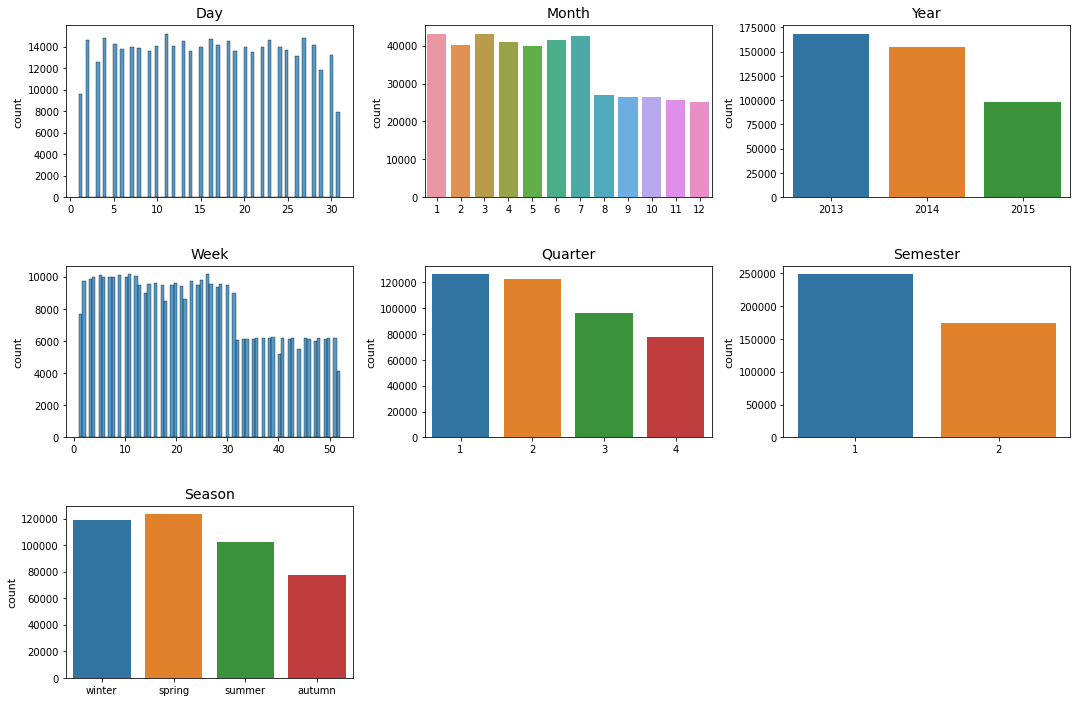

In [58]:
plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace=0.4,wspace=0.25)

plt.subplot(3,3,1)
ax = sns.histplot(dados['day'])
ax.set_title('Day',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,2)
ax = sns.countplot(dados['month'])
ax.set_title('Month',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,3)
ax = sns.countplot(dados['year'])
ax.set_title('Year',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,4)
ax = sns.histplot(dados['week'])
ax.set_title('Week',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,5)
ax = sns.countplot(dados['quarter'])
ax.set_title('Quarter',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,6)
ax = sns.countplot(dados['semester'])
ax.set_title('Semester',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,7)
ax = sns.countplot(dados['season'])
ax.set_title('Season',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)


plt.show()

What we can observe:

**Day:** We have a similar representation between values, but the first and the last that of the month we have less records for some reason.

**Month, Week, Semester and Quarter:** Most of the records are from the first semester, probably because 2015 is not completed yet.

**Year:** As we talked all time, 2015 has less records. But 2014 has less than 2013 for some reason.

**Season:** Not have a equal distribution, probably because of the semesters representation difference

**RESUMO:** A distribuição de tempo no dataset não é muito bem distribuída, tem lacunas em algumas partes do ano e ao longo dos anos! Temos que considerar essa falta de homogeneidade para fazer nossas análises!

## 2.3 Bivariate Analysis

### H1: As lojas vendem mais no começo do mês do que no final

The hypotheis is **TRUE** and this feature seems to have a **HIGH** impact on Machine Learning Model.

Vemos que no ano como um todo se vende um pouco mais no começo do que no final, mas esse comportamento depende muito de que mês estamos falando. O que me chamou atenção é esse comportamento bem característico no primeiro gráfico, provavelmente será uma feature importante.

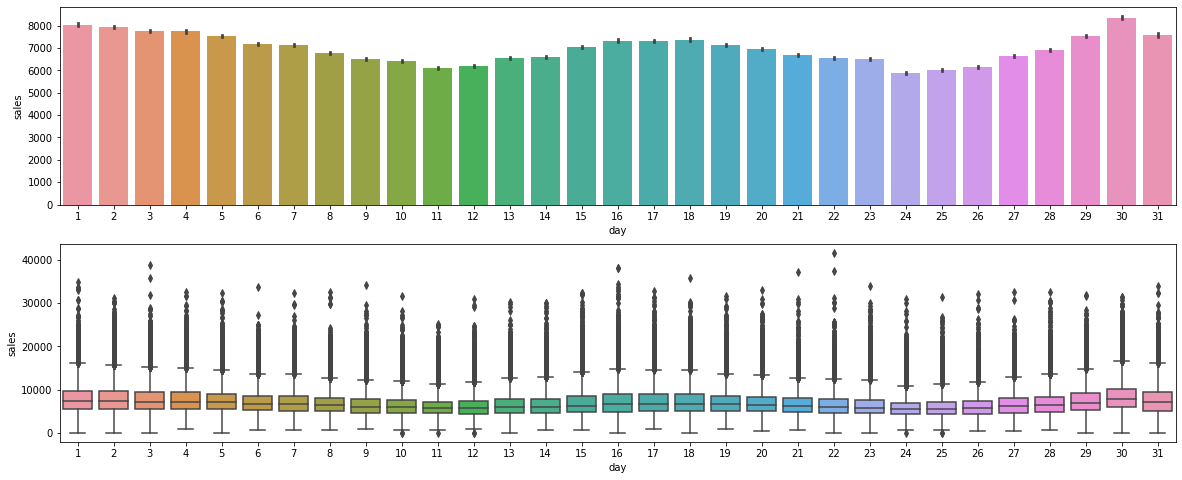

In [64]:
plt.figure(figsize=(20,8))

plt.subplot(2,1,1)
ax = sns.barplot(x=dados['day'],y=dados['sales'])

plt.subplot(2,1,2)
ax = sns.boxplot(x=dados['day'],y=dados['sales'])

plt.show()

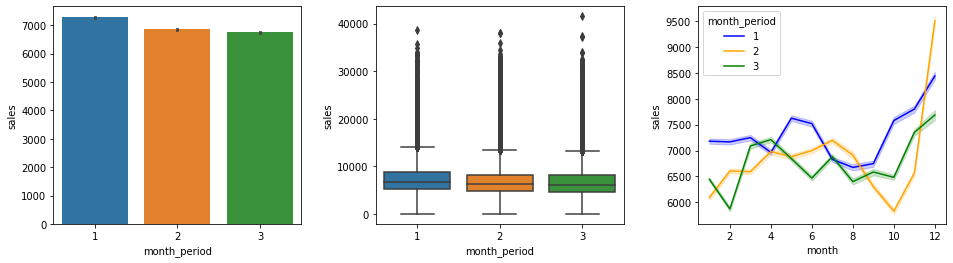

In [61]:
# 1 == 10 first days, 2 == 10 middle days, 3 == 10* (* == or 11) ending days
month_period = dados['day'].apply(lambda x: 1 if x<=10 else (2 if 20>=x>=11 else 3)) 

plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
ax = sns.barplot(x=month_period,y=dados['sales'])
ax.set_xlabel('month_period')

plt.subplot(1,3,2)
ax = sns.boxplot(x=month_period,y=dados['sales'])
ax.set_xlabel('month_period')

plt.subplot(1,3,3)
ax = sns.lineplot(x=dados['month'],y=dados['sales'],hue=month_period,palette=['blue','orange','green'])
ax.legend(title='month_period')
plt.show()

### H2: Houve um crescimento de vendas ao longo dos anos

The hypothesis ask for a absolute value analyses, but as we saw on the univariate analysis, these classes are not well balanced.

Then, analysing relative values, the hypothesis is **TRUE**, we can see this in graphs and with describe method.

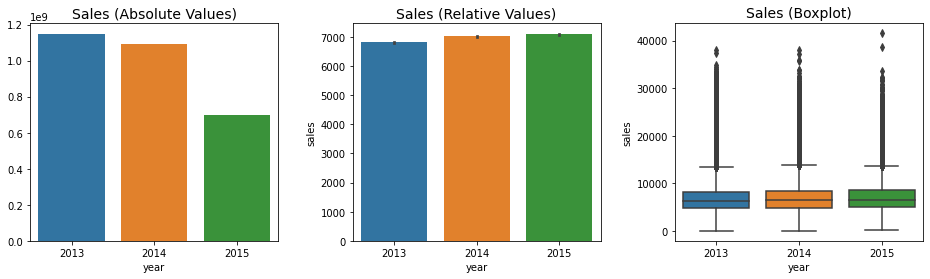

In [65]:
plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
ax = sns.barplot(x=dados.groupby('year').sum()['sales'].index,y=dados.groupby('year').sum()['sales'].values)
ax.set_title('Sales (Absolute Values)',size=14)

plt.subplot(1,3,2)
ax = sns.barplot(x=dados['year'],y=dados['sales'])
ax.set_title('Sales (Relative Values)',size=14)

plt.subplot(1,3,3)
ax = sns.boxplot(x=dados['year'],y=dados['sales'])
ax.set_title('Sales (Boxplot)',size=14)

plt.show()

In [17]:
# Tradicional Descriptive Analysis of sales over the years
dados.groupby('year').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,67771.0,6817.858553,3126.440146,0.0,4716.0,6207.0,8196.0,38025.0
2014,61919.0,7012.757054,3116.122494,416.0,4900.0,6432.0,8446.5,33913.0
2015,39284.0,7087.757102,3025.404608,124.0,5047.0,6541.0,8504.0,32228.0


In [67]:
# Analysing the percentage of increasment over the years
round(dados.groupby('year').describe()['sales'].pct_change()*100,2)

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,-7.98,3.06,0.21,NaN,3.90,3.54,3.32,0.03
2015,-36.67,0.94,-3.39,inf,3.06,1.73,0.54,9.24


<AxesSubplot:xlabel='year', ylabel='sales_per_customer'>

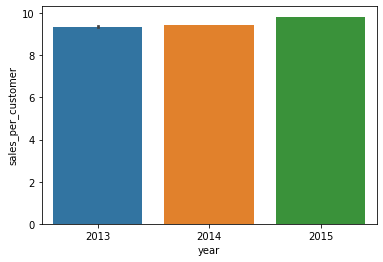

In [58]:
sns.barplot(x=dados['year'],y=dados['sales_per_customer'])

### H3: Lojas vendem mais no fim de semana

The hypothesis is **FALSE** and this feature seems to have a **HIGH** impact on Machine Learning Model.

We can clearly see a high difference in the first 3 graphs, week days has way more sales all over the year. In the last 3 graphs we can see that sunday is the best day of the week for sales. So, why we can claim that this hypothesis is false? We need to remember what we observed in univariate analysis: most of times stores doesn't even open on sunday's. So probably the stores only opens on especific sundays, which they know that it will be very worth it! Beyond that, this feature also have a very particular behavior, for me it seems to have huge importance for the model that we will build.

About sales per customer: Mesmo com um claro volume de vendas menos nos fins de semana, os consumidores não diminuem seu consumo. Na verdade o que acontece é um menor fluxo nesse período! Outra descoberta interessante é que nos domingos que são abertos, onde vimos um volume de vendas muito maior que o usual, os consumidores consomem menos! Então o que há, pra gerar maiores sales, é apenas um fluxo maior de consumidores!

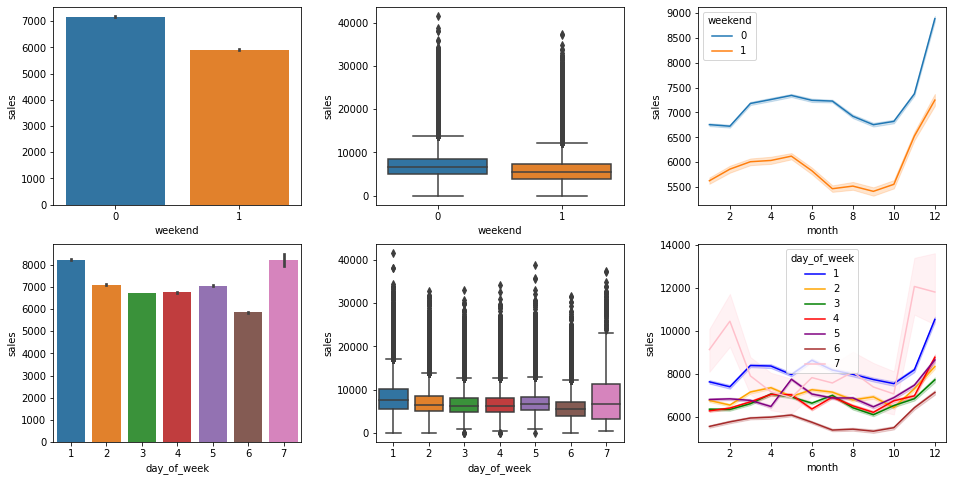

In [68]:
weekend = dados['day_of_week'].apply(lambda x: 1 if x==6 or x==7 else 0)

plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
ax = sns.barplot(x=weekend,y=dados['sales'])
ax.set_xlabel('weekend')

plt.subplot(2,3,2)
ax = sns.boxplot(x=weekend,y=dados['sales'])
ax.set_xlabel('weekend')

plt.subplot(2,3,3)
ax = sns.lineplot(x=dados['month'],y=dados['sales'],hue=weekend)
ax.legend(title='weekend')

plt.subplot(2,3,4)
sns.barplot(x=dados['day_of_week'],y=dados['sales'])

plt.subplot(2,3,5)
sns.boxplot(x=dados['day_of_week'],y=dados['sales'])

plt.subplot(2,3,6)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['day_of_week'],palette=['blue','orange','green','red','purple','brown','pink'])

plt.show()

In [ ]:
# Sales per customer

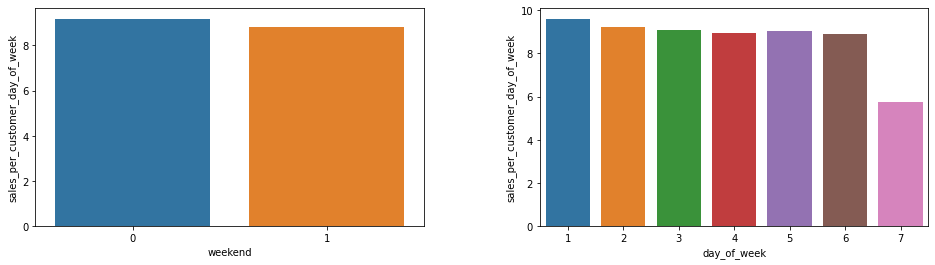

In [239]:
weekend = dados['day_of_week'].apply(lambda x: 1 if x==6 or x==7 else 0)

plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
ax = sns.barplot(x=weekend,y=dados['sales_per_customer_day_of_week'])
ax.set_xlabel('weekend')

plt.subplot(1,2,2)
sns.barplot(x=dados['day_of_week'],y=dados['sales_per_customer_day_of_week'])

plt.show()

### H4: Lojas vendem mais em feriados

For 'State Holiday' and 'School Holiday' the hypothesis is **TRUE**

Os feriados do tipo 'State Holiday' possuem distribuições menos comportadas, mas em geral com valores maiores do que dias normais. About sales per customer: Impressionantemente, mesmo com menores vendas, os consumidores gastam mais em dias normais! Certamente é um insight interessante!

Os feriados do tipo 'School Holiday' em uma primeira vista parecem vender apenas um pouco mais, mas em 10 meses do ano vemos diferenças consideráveis de venda! O interessante é que em 2 meses vemos o inverso, mas em geral o comportamento nos informa que a hipótese é verdadeira. 

In [69]:
# State holiday (w/ sales per customer analysis)

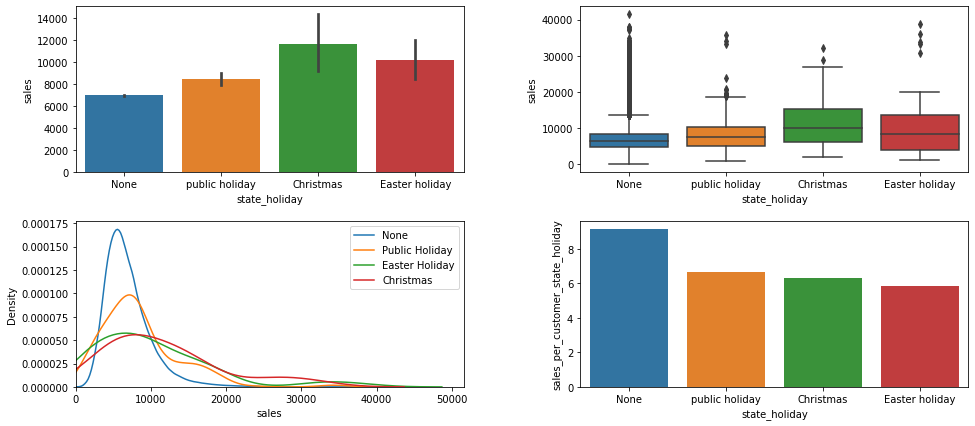

In [246]:
plt.figure(figsize=(16,7))
plt.subplots_adjust(wspace=0.3,hspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['state_holiday'],y=dados['sales'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['state_holiday'],y=dados['sales'])

plt.subplot(2,2,3)
sns.kdeplot(dados[dados['state_holiday']=='None']['sales'])
sns.kdeplot(dados[dados['state_holiday']=='public holiday']['sales'])
sns.kdeplot(dados[dados['state_holiday']=='Easter holiday']['sales'])
sns.kdeplot(dados[dados['state_holiday']=='Christmas']['sales'])
plt.legend(['None','Public Holiday','Easter Holiday','Christmas'])
plt.xlim(dados['sales'].min())

plt.subplot(2,2,4)
sns.barplot(x=dados['state_holiday'],y=dados['sales_per_customer_state_holiday'])

plt.show()

In [71]:
# I want to analyse more accuractely the difference between easter, public holiday and normal days
dados.groupby('state_holiday').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
state_holiday,,,,,,,,
Christmas,32.0,11612.312500,7655.209478,1929.0,6147.75,9960.5,15187.75,32169.0
Easter holiday,85.0,10189.211765,8059.917644,1071.0,3953.00,8364.0,13583.00,38722.0
None,421650.0,6952.715750,3105.943112,0.0,4855.00,6366.0,8357.00,41551.0
public holiday,344.0,8425.604651,5158.246219,1010.0,4959.50,7546.0,10437.25,35702.0


In [197]:
# School Holiday (w/ sales per customer analysis)

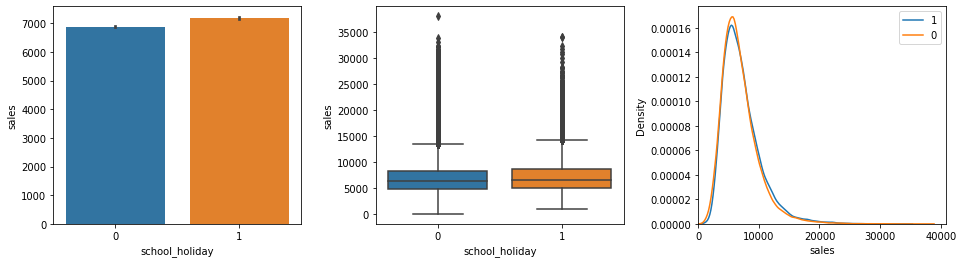

In [198]:
plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
sns.barplot(x=dados['school_holiday'],y=dados['sales'])

plt.subplot(1,3,2)
sns.boxplot(x=dados['school_holiday'],y=dados['sales'])

plt.subplot(1,3,3)
sns.kdeplot(dados[dados['school_holiday']==1]['sales'])
sns.kdeplot(dados[dados['school_holiday']==0]['sales'])
plt.legend(['1','0'])
plt.xlim(dados['sales'].min())

plt.show()

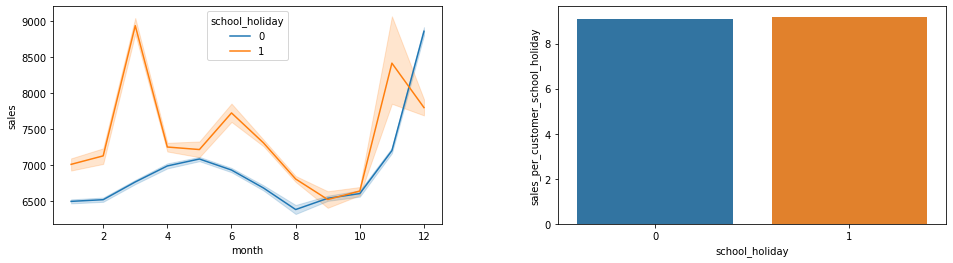

In [252]:
# Want to see if this 'no difference' between classes is present in the whole year

plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['school_holiday']);

plt.subplot(1,2,2)
sns.barplot(x=dados['school_holiday'],y=dados['sales_per_customer_school_holiday']);

plt.show()

We need to investigate this different behavior, because at the first look the classes seems to have no impact on sales.

In [200]:
# Let's go deeper and analyse using descriptive analysis
df_aux = pd.DataFrame()
df_aux1 = dados[dados['school_holiday']==1].groupby('month').describe()['sales']
df_aux0 = dados[dados['school_holiday']==0].groupby('month').describe()['sales']
for column in df_aux1.columns.values:
    df_aux[f'{column} sc==0'] = df_aux0[column]
    df_aux[f'{column} sc==1'] = df_aux1[column]
    df_aux[f'{column} diff sc1 - sc0'] = df_aux[f'{column} sc==1']-df_aux[f'{column} sc==0']
    df_aux[f'{column} pct sc1/sc0'] = round(((df_aux[f'{column} sc==1']/df_aux[f'{column} sc==0'])-1)*100,2)
    df_aux[f'{column}'] = pd.Series([0,0,0,0,0,0,0,0,0,0,0,0,0])
df_aux

,count sc==0,count sc==1,count diff sc1 - sc0,count pct sc1/sc0,count,mean sc==0,mean sc==1,mean diff sc1 - sc0,mean pct sc1/sc0,mean,std sc==0,std sc==1,std diff sc1 - sc0,std pct sc1/sc0,std,min sc==0,min sc==1,min diff sc1 - sc0,min pct sc1/sc0,min,25% sc==0,25% sc==1,25% diff sc1 - sc0,25% pct sc1/sc0,25%,50% sc==0,50% sc==1,50% diff sc1 - sc0,50% pct sc1/sc0,50%,75% sc==0,75% sc==1,75% diff sc1 - sc0,75% pct sc1/sc0,75%,max sc==0,max sc==1,max diff sc1 - sc0,max pct sc1/sc0,max
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14899.0,2227.0,-12672.0,-85.05,0,6519.518290,7006.862595,487.344306,7.48,0,2816.059047,2983.266680,167.207633,5.94,0,0.0,1198.0,1198.0,inf,0,4613.00,4991.50,378.50,8.21,0,6029.0,6426.0,397.0,6.58,0,7859.50,8405.50,546.00,6.95,0,32263.0,32228.0,-35.0,-0.11,0
2,14548.0,1384.0,-13164.0,-90.49,0,6492.128196,7242.730491,750.602295,11.56,0,2810.086002,3262.302220,452.216218,16.09,0,625.0,1641.0,1016.0,162.56,0,4617.00,5027.75,410.75,8.90,0,6028.5,6684.5,656.0,10.88,0,7790.00,8583.00,793.00,10.18,0,31448.0,31649.0,201.0,0.64,0
3,15659.0,1482.0,-14177.0,-90.54,0,6741.606808,8885.419703,2143.812896,31.80,0,2977.891935,3641.195352,663.303417,22.27,0,599.0,2141.0,1542.0,257.43,0,4741.00,6266.50,1525.50,32.18,0,6172.0,8305.5,2133.5,34.57,0,8096.00,10671.25,2575.25,31.81,0,28165.0,30729.0,2564.0,9.10,0
4,12514.0,4001.0,-8513.0,-68.03,0,6993.815007,7201.268183,207.453176,2.97,0,3118.830573,3149.850349,31.019777,0.99,0,416.0,1250.0,834.0,200.48,0,4851.50,4975.00,123.50,2.55,0,6414.5,6493.0,78.5,1.22,0,8496.00,8672.00,176.00,2.07,0,30848.0,29944.0,-904.0,-2.93,0
5,14777.0,1242.0,-13535.0,-91.60,0,7077.202680,7338.587762,261.385082,3.69,0,2953.281076,3226.165145,272.884069,9.24,0,923.0,2272.0,1349.0,146.15,0,5112.00,5117.25,5.25,0.10,0,6581.0,6737.5,156.5,2.38,0,8489.00,8752.50,263.50,3.10,0,33151.0,34133.0,982.0,2.96,0
6,15498.0,1176.0,-14322.0,-92.41,0,6943.552587,7745.228741,801.676154,11.55,0,3129.248048,3229.557069,100.309020,3.21,0,0.0,2409.0,2409.0,inf,0,4857.25,5472.75,615.50,12.67,0,6296.0,7070.5,774.5,12.30,0,8307.75,9319.00,1011.25,12.17,0,31477.0,27177.0,-4300.0,-13.66,0
7,9444.0,7719.0,-1725.0,-18.27,0,6699.277319,7311.012307,611.734988,9.13,0,2865.273620,3134.453509,269.179889,9.39,0,943.0,1143.0,200.0,21.21,0,4756.75,5095.00,338.25,7.11,0,6227.0,6724.0,497.0,7.98,0,8053.75,8829.00,775.25,9.63,0,30112.0,27508.0,-2604.0,-8.65,0
8,4126.0,6770.0,2644.0,64.08,0,6360.342705,6797.103250,436.760545,6.87,0,3164.460540,2781.390174,-383.070365,-12.11,0,316.0,1007.0,691.0,218.67,0,4309.00,4859.25,550.25,12.77,0,5802.5,6304.5,502.0,8.65,0,7703.25,8178.75,475.50,6.17,0,33913.0,23970.0,-9943.0,-29.32,0
9,9668.0,873.0,-8795.0,-90.97,0,6527.875052,6515.844215,-12.030836,-0.18,0,2840.517568,2779.255562,-61.262006,-2.16,0,740.0,1573.0,833.0,112.57,0,4623.00,4407.00,-216.00,-4.67,0,5961.0,6020.0,59.0,0.99,0,7824.25,7809.00,-15.25,-0.19,0,29777.0,21535.0,-8242.0,-27.68,0


### H5: Lojas vendem mais no segundo semestre

The hypothesis is **TRUE**

As vendas são muito parecidas, mas em geral vemos um aumento nas vendas, acredito que 2015 não apresentou por não abranger todo o ano, especialmente o final, com datas comemorativas que já vimos puxar as vendas para cima!

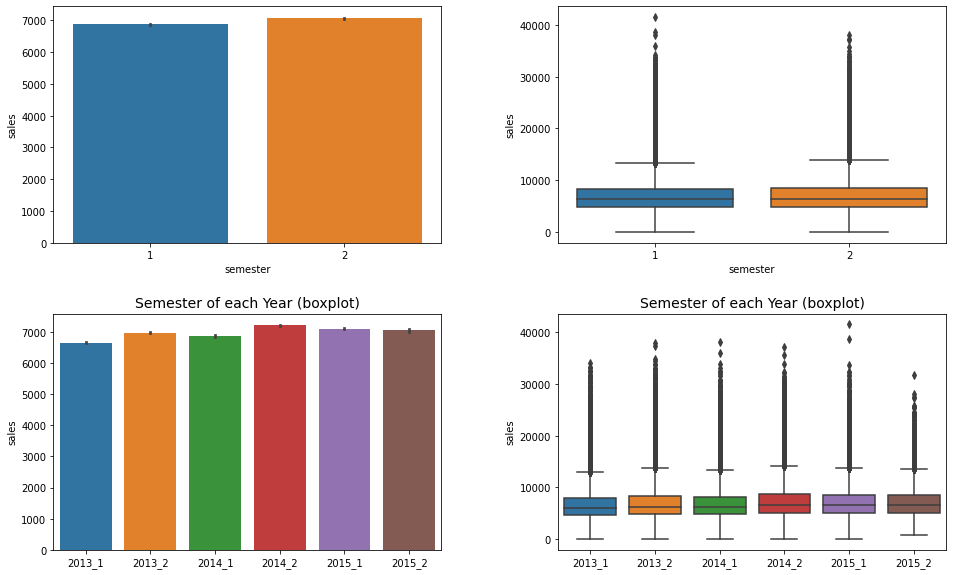

In [4]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.3,hspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['semester'],y=dados['sales'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['semester'],y=dados['sales'])


# Let's see if this happens every year
plt.subplot(2,2,3)
year_semester = dados.apply(lambda x: str(x['year'])+'_'+str(x['semester']), axis=1)
ax = sns.barplot(x=year_semester,y=dados['sales'],order=['2013_1','2013_2','2014_1','2014_2','2015_1','2015_2'])
ax.set_title('Semester of each Year (boxplot)',size=14)

plt.subplot(2,2,4)
ax = sns.boxplot(x=year_semester,y=dados['sales'],order=['2013_1','2013_2','2014_1','2014_2','2015_1','2015_2'])
ax.set_title('Semester of each Year (boxplot)',size=14)

plt.show()

In [5]:
dados.groupby('semester').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
semester,,,,,,,,
1,248693.0,6872.163885,3031.135614,0.0,4827.0,6309.0,8259.00,41551.0
2,173418.0,7073.600364,3219.280797,0.0,4897.0,6457.0,8509.75,38025.0


The hypothesis is **FALSE**

Podemos ver que em geral, ao menos em 2013 e 2014 (pois 2015 não existe registro), o último trimestre é onde há maior número de vendas.

O terceiro trimestre geralmente vende até menos que o segundo, e parecido com o primeiro, o que corrobora ainda mais com a conclusão da hipótese 5.

### H6: Lojas vendem mais no verão

The hypothesis is **FALSE**

Há mais vendas, em todos os anos, nos períodos de primavera e outono (Apenas é necessário lembrar que não temos registros do outono de 2015)

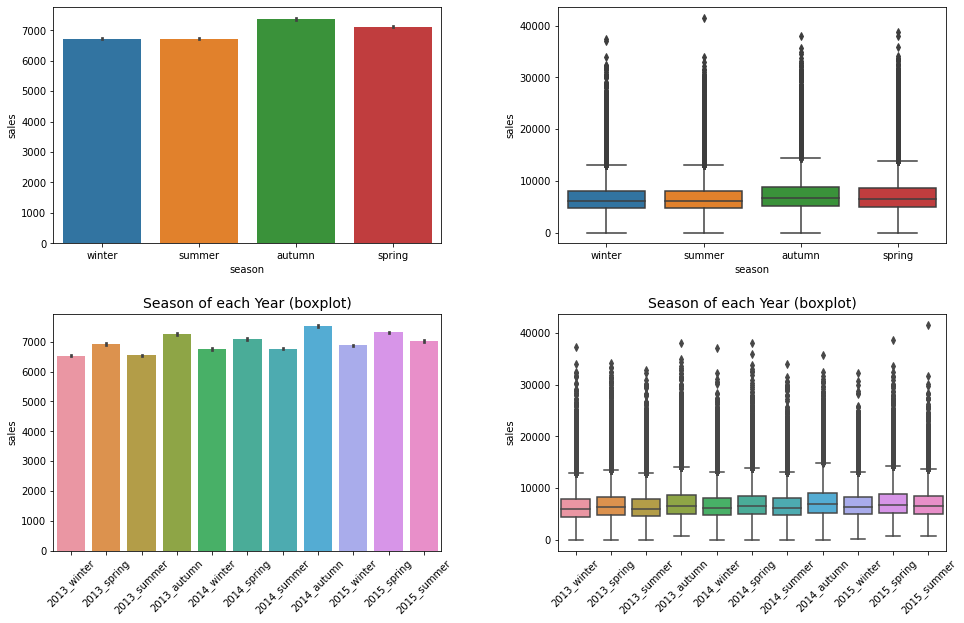

In [12]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.3,hspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['season'],y=dados['sales'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['season'],y=dados['sales'])


# Let's see if this happens every year
plt.subplot(2,2,3)
year_season = dados.apply(lambda x: str(x['year'])+'_'+str(x['season']), axis=1)
order = ['2013_winter', '2013_spring', '2013_summer', '2013_autumn','2014_winter', '2014_spring', '2014_summer', '2014_autumn','2015_winter','2015_spring', '2015_summer']
ax = sns.barplot(x=year_season,y=dados['sales'],order=order)
ax.set_title('Season of each Year (boxplot)',size=14)
plt.tick_params(axis='x',rotation=45)

plt.subplot(2,2,4)
ax = sns.boxplot(x=year_season,y=dados['sales'],order=order)
ax.set_title('Season of each Year (boxplot)',size=14)
plt.tick_params(axis='x',rotation=45)

plt.show()

### H8: Se a loja tem competidor ela vende menos

The hypothesis is **TRUE**

Vemos uma diferença sutil nos gráficos observados, o que foi confirmado com a análise descritiva, mas ela existe, assim como esperávamos.

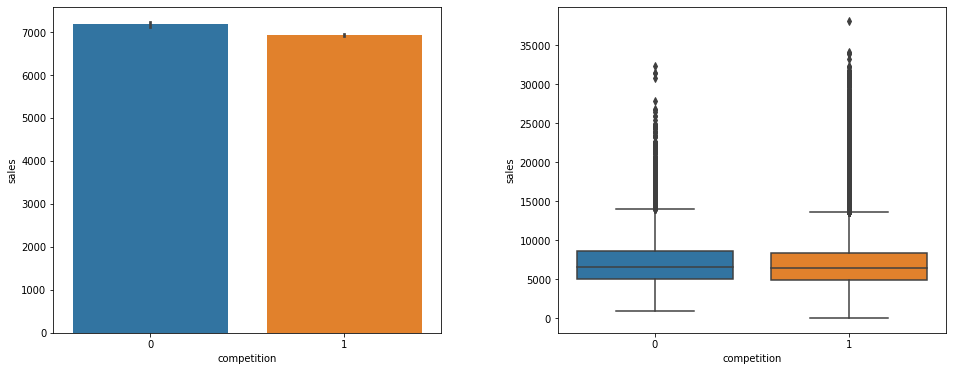

In [205]:
plt.figure(figsize=(16,6))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['competition'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['competition'],y=dados['sales'])

plt.show()

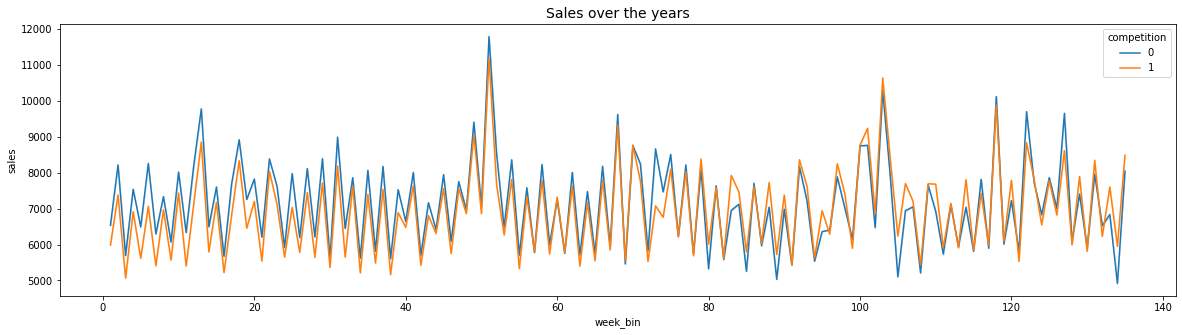

In [206]:
# let's see if this occurred all over the years

plt.figure(figsize=(20,5))
ax = sns.lineplot(dados['week_bin'],dados['sales'],hue=dados['competition'],ci=False)
ax.set_title('Sales over the years',size=14)
plt.show()

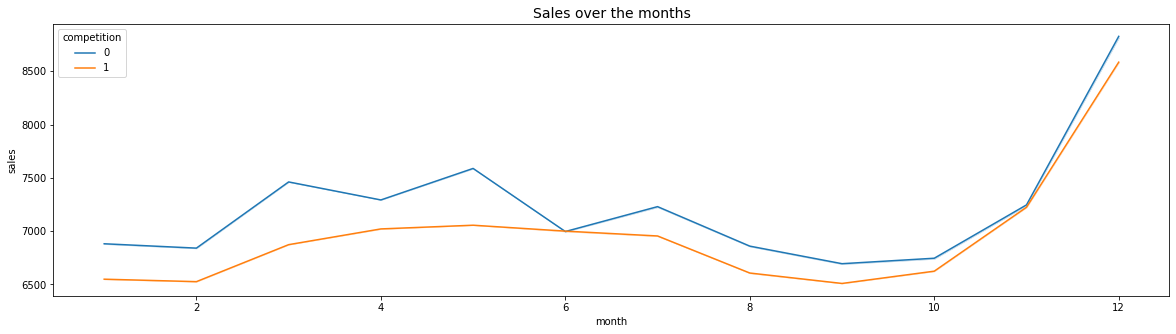

In [207]:
# let's see if this occurred all over the month

plt.figure(figsize=(20,5))
ax = sns.lineplot(dados['month'],dados['sales'],hue=dados['competition'],ci=False)
ax.set_title('Sales over the months',size=14)
plt.show()

In [208]:
# descriptive analysis
dados.groupby('competition').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
competition,,,,,,,,
0,14405.0,7175.756335,3184.335609,898.0,5036.0,6586.0,8620.0,32355.0
1,154569.0,6931.174272,3092.846876,0.0,4845.0,6345.0,8335.0,38025.0


### H9: Quanto mais velha é a competição, menos a loja vende

Tendência quase nula, reta de regressão na horizontal! 

Logo, baseado nessas informações que temos: This hypothesis is **FALSE**

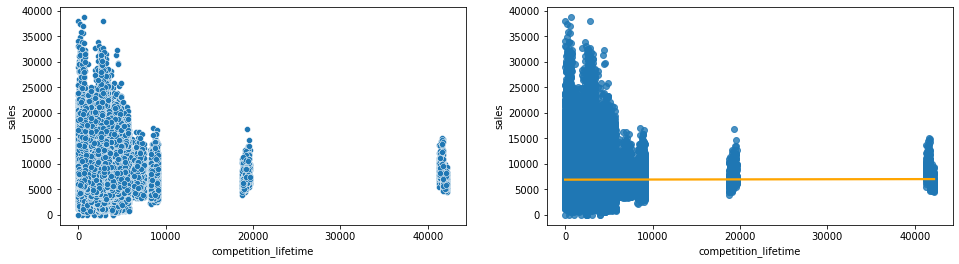

In [19]:
df_aux = dados[dados['competition']==1] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_lifetime'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_lifetime'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [20]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_lifetime','sales']))

Coeficiente de Correlação de Pearson: 0.0018458520195225457


Acho que esses dois focos, em x = 20000 e 40000 são de duas lojas específicas que podem atrapalhar nossa análise, são claramente outliers.

In [21]:
# Finding how many stores are
print('Quantidade de lojas dos dois focos: {} stores'.format(dados[dados['competition_lifetime']>15000]['store'].unique().shape[0]))

Quantidade de lojas dos dois focos: 2 stores


São de fato duas lojas que estão atrapalhando, vamos retirá-las para vermos melhor a tendência no gráfico de dispersão.

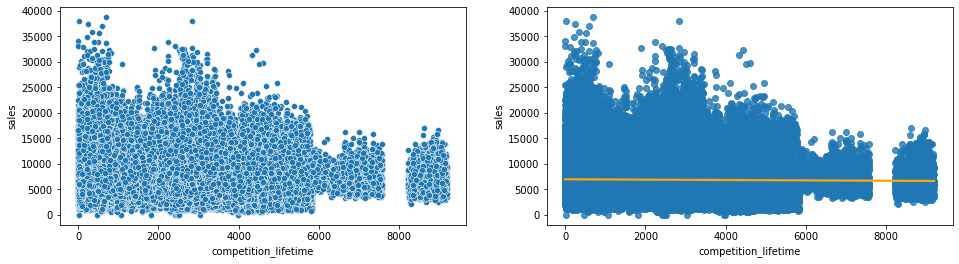

In [22]:
df_aux = df_aux[df_aux['competition_lifetime']<15000] # Removing these two stores

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_lifetime'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_lifetime'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [23]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_lifetime','sales']))

Coeficiente de Correlação de Pearson: -0.017683954926754102


### H10 Quanto mais longe é o competidor, mais vende a loja

Tendência quase nula, reta de regressão na horizontal! 

Logo, baseado nessas informações que temos: This hypothesis is **FALSE**

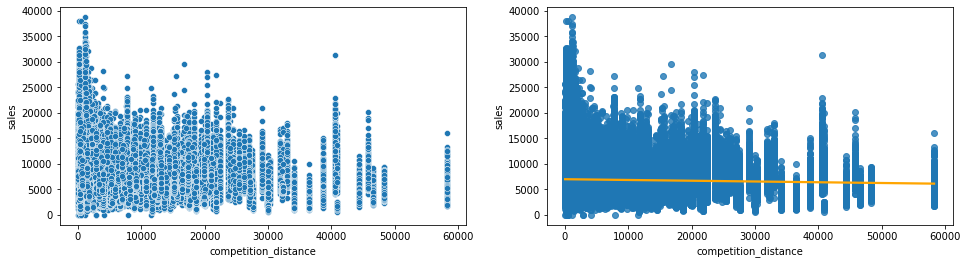

In [29]:
df_aux = dados[dados['competition']==1] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_distance'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_distance'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [30]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_distance','sales']))

Coeficiente de Correlação de Pearson: -0.037517955119866164


### H11: Existem tipos de loja que vendem substancialmente mais

This hypothesis is **TRUE** and this feature seems to have a huge impact on ML model.

Vemos claramente que existe um tipo de loja que vende muito mais que os outros, o tipo B. About sales per customer: em contrapartida, vemos que ele é o que menos vende por consumidor, e o tipo D vende absolutamente mais que qualquer store type, o que é um grande insight para o business team!

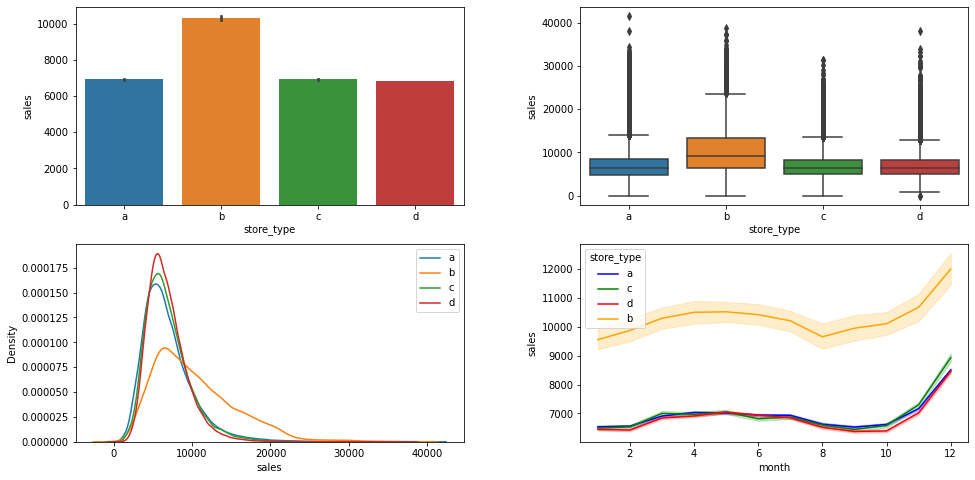

In [36]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['store_type'],y=dados['sales'],order=['a','b','c','d'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['store_type'],y=dados['sales'],order=['a','b','c','d'])

plt.subplot(2,2,3)
sns.kdeplot(x=dados[dados['store_type']=='a']['sales'])
sns.kdeplot(x=dados[dados['store_type']=='b']['sales'])
sns.kdeplot(x=dados[dados['store_type']=='c']['sales'])
sns.kdeplot(x=dados[dados['store_type']=='d']['sales'])
plt.legend(['a','b','c','d'])

plt.subplot(2,2,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['store_type'],palette=['blue','green','red','orange'])

plt.show()

In [37]:
# descriptive analysis
dados.groupby(dados['store_type']).describe()['sales']

,count,mean,std,min,25%,50%,75%,max
store_type,,,,,,,,
a,228503.0,6919.618758,3282.432873,0.0,4687.00,6278.0,8396.0,41551.0
b,7827.0,10283.173885,5200.952778,0.0,6353.00,9169.0,13255.5,38722.0
c,56351.0,6927.218452,2907.355158,0.0,4903.00,6394.0,8341.0,31448.0
d,129430.0,6828.037912,2558.522417,0.0,5054.25,6402.0,8133.0,38037.0


In [39]:
# Sales per customers

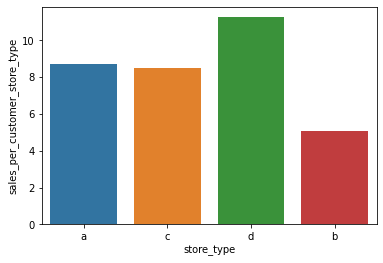

In [40]:
sns.barplot(x=dados['store_type'],y=dados['sales_per_customer_store_type']);

### H12: Quanto mais diversa é a loja, mais ela vende

This Hypothesis is **TRUE** and this feature seems to have a huge impact on ML model.

É visível uma correlação positiva na relação entre assortment e sales. A extra desponta como a com maior volume de vendas, seguida pela extended e depois pela basic. About sales per customer: Da mesma forma que o store type, o resultado foi contra intuitivo, com extra sendo a com pior desempenho e a extended com maior, demonstrando que para o consumidor desembolsar mais, ele deve ter uma variedade mediana. Certamente outro grande insight!

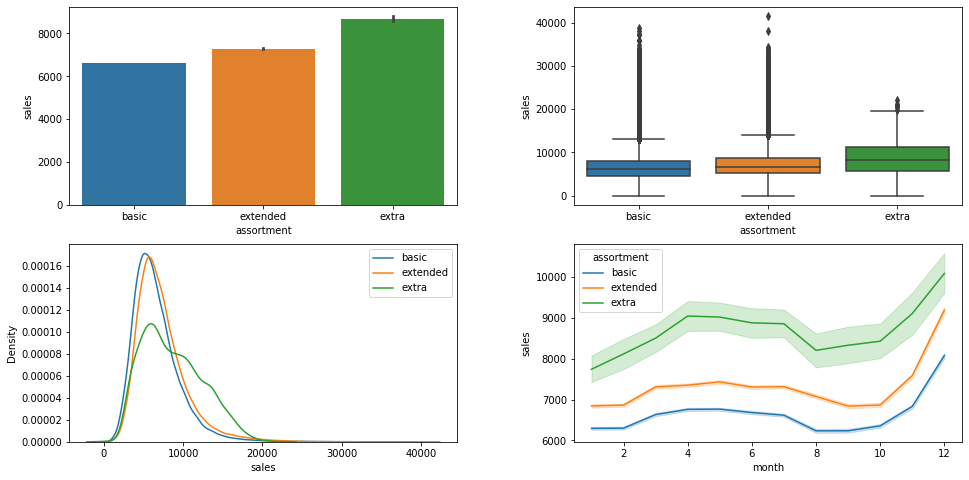

In [41]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['assortment'],y=dados['sales'],order=['basic','extended','extra'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['assortment'],y=dados['sales'],order=['basic','extended','extra'])

plt.subplot(2,2,3)
sns.kdeplot(x=dados[dados['assortment']=='basic']['sales'])
sns.kdeplot(x=dados[dados['assortment']=='extended']['sales'])
sns.kdeplot(x=dados[dados['assortment']=='extra']['sales'])
plt.legend(['basic','extended','extra'])

plt.subplot(2,2,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['assortment'])

plt.show()

In [42]:
# descriptive analysis
dados.groupby(dados['assortment']).describe()['sales']

,count,mean,std,min,25%,50%,75%,max
assortment,,,,,,,,
basic,222130.0,6624.664035,2985.757800,0.0,4605.00,6082.0,8004.00,38722.0
extended,195801.0,7292.946946,3185.827560,0.0,5154.00,6671.0,8695.00,41551.0
extra,4180.0,8671.233014,3786.550697,0.0,5616.75,8143.5,11288.75,22137.0


In [43]:
# Sales per customer

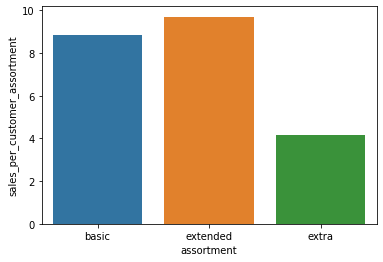

In [45]:
sns.barplot(x=dados['assortment'],y=dados['sales_per_customer_assortment']);

### H13: Quando tem promoção as lojas vendem mais

This hypothesis is **TRUE** and this variable seems to have a huge impact on ML model.

É clara a diferença entre promo e sem promo, salto enorme de vendas!

Há algo que me chamou a atenção: não existem promo no weekend, o que pode explicar o porquê de vender tão mal nesse período, como visto na H3.

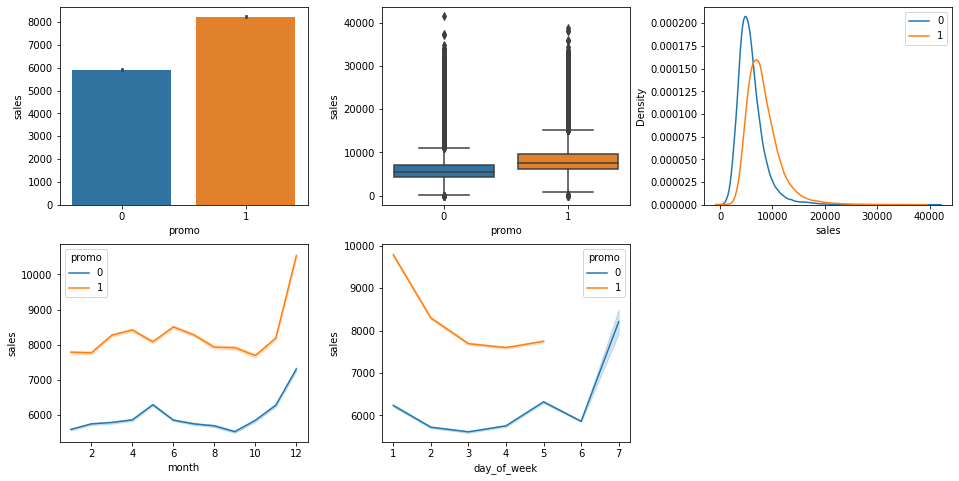

In [46]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
sns.barplot(x=dados['promo'],y=dados['sales'])

plt.subplot(2,3,2)
sns.boxplot(x=dados['promo'],y=dados['sales'])

plt.subplot(2,3,3)
sns.kdeplot(x=dados[dados['promo']==0]['sales'])
sns.kdeplot(x=dados[dados['promo']==1]['sales'])
plt.legend(['0','1'])

plt.subplot(2,3,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['promo'])

plt.subplot(2,3,5)
sns.lineplot(x=dados['day_of_week'],y=dados['sales'],hue=dados['promo'])

plt.show()

In [47]:
# descriptive analysis
dados.groupby(dados['promo']).describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo,,,,,,,,
0,233655.0,5921.508656,2624.623479,0.0,4237.0,5454.0,7000.0,41551.0
1,188456.0,8236.185507,3190.103153,0.0,6071.0,7648.0,9697.0,38722.0


### H14: Quanto mais vezes se tem promoção em um período, menos eficaz ela fica

This hypothesis is **FALSE** and this feature seems to have a huge impact on ML model.

A gente claramente vê que os dias entre promoções são iguais àqueles de semanas sem promoção, não há uma queda nas vendas. O que vemos é que o primeiro dia é o mais efetivo e que há uma queda na efetividade na segunda promoção em diante, mas mantendo um volume de vendas regular, ainda bem superior à dias sem promo.

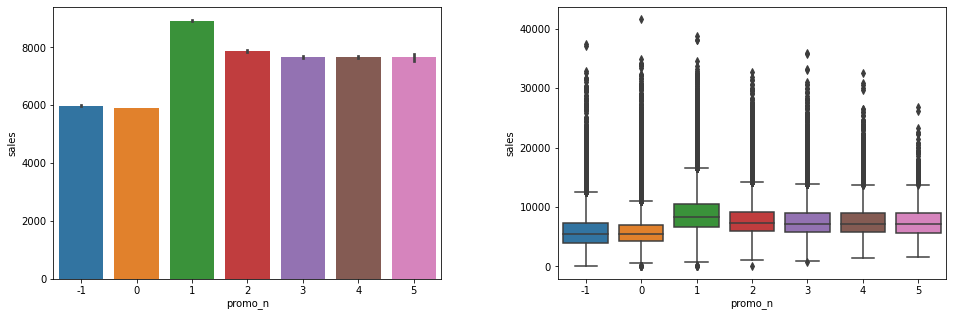

In [52]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['promo_n'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['promo_n'],y=dados['sales'])

plt.show()

In [53]:
# Descriptive Analysis
dados.groupby('promo_n').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo_n,,,,,,,,
-1,37840.0,5990.611549,3033.621723,124.0,3964.75,5491.0,7360.00,37376.0
0,195815.0,5908.154963,2537.791409,0.0,4276.00,5448.0,6937.00,41551.0
1,74886.0,8922.874796,3440.908513,0.0,6570.00,8326.0,10542.00,38722.0
2,61502.0,7873.653426,2964.447821,0.0,5890.00,7352.0,9202.00,32764.0
3,36731.0,7679.984291,2884.189181,816.0,5745.00,7178.0,8982.50,35909.0
4,13317.0,7670.179920,2860.269747,1426.0,5763.00,7179.0,8958.00,32529.0
5,2020.0,7662.104950,2866.986898,1542.0,5680.00,7145.0,8917.25,26869.0


### H15: Quanto mais vezes se tem promoção em um período, mais a loja vende

This hypothesis is **FALSE**

Vemos muita pouca diferença e na análise descritiva fica claro, apesar da tendência, que 5 promos vendem menos que 4, então não poderíamos concluir que essa hipótese é verdadeira!

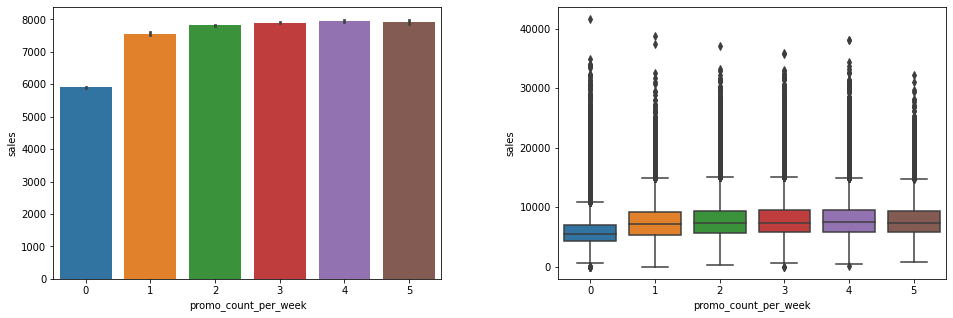

In [59]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['promo_count_per_week'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['promo_count_per_week'],y=dados['sales'])

plt.show()

In [60]:
# Descriptive Analysis
dados.groupby('promo_count_per_week').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo_count_per_week,,,,,,,,
0,195815.0,5908.154963,2537.791409,0.0,4276.00,5448.0,6937.00,41551.0
1,20069.0,7567.209776,3364.643855,0.0,5331.00,7070.0,9134.00,38722.0
2,62155.0,7815.428912,3280.125298,316.0,5629.00,7304.0,9391.00,37122.0
3,81966.0,7903.879230,3254.969630,0.0,5739.00,7362.0,9436.00,35909.0
4,50970.0,7948.962056,3249.849848,124.0,5784.00,7425.0,9435.75,38037.0
5,11136.0,7920.351922,3281.680028,804.0,5738.75,7329.0,9339.00,32170.0


### H16: Se a loja acatar a promo2 ela vende mais

This hipothesis is **FALSE** and this feature seems to have a huge impact on ML model.

Certamente isso é um grande insight para a empresa: a promo2 na verdade diminui o volume de vendas da loja! About sales per customer: Incrivelmente vemos que lojas com promo2 fazem os consumidores gastarem mais, o que é bem contra intuitivo com a conclusão anterior, o que também é um insight de enorme valor para a empresa!

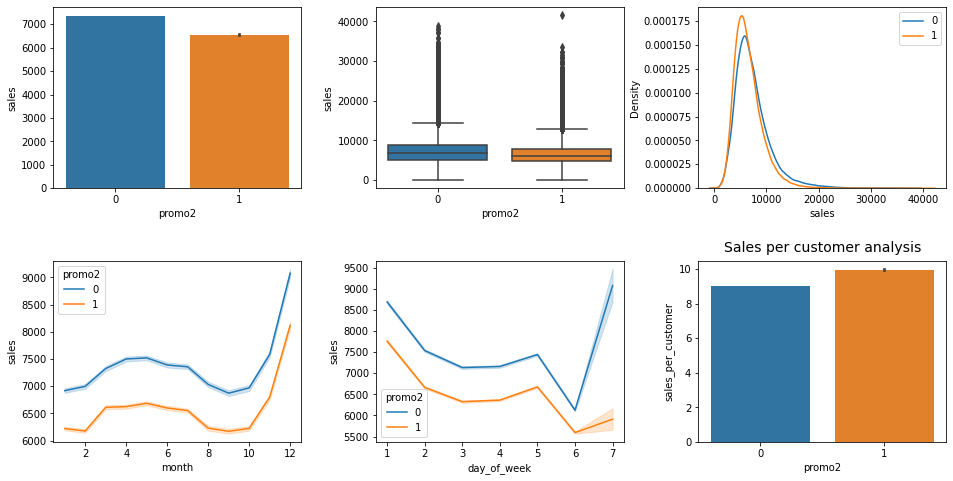

In [65]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3,hspace=0.4)

plt.subplot(2,3,1)
sns.barplot(x=dados['promo2'],y=dados['sales'])

plt.subplot(2,3,2)
sns.boxplot(x=dados['promo2'],y=dados['sales'])

plt.subplot(2,3,3)
sns.kdeplot(x=dados[dados['promo2']==0]['sales'])
sns.kdeplot(x=dados[dados['promo2']==1]['sales'])
plt.legend(['0','1'])

plt.subplot(2,3,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['promo2'])

plt.subplot(2,3,5)
sns.lineplot(x=dados['day_of_week'],y=dados['sales'],hue=dados['promo2'])

plt.subplot(2,3,6)
ax = sns.barplot(x=dados['promo2'],y=dados['sales_per_customer'])
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.show()

In [246]:
# Descriptive Analysis
dados.groupby('promo2').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo2,,,,,,,,
0,84787.0,7345.566231,3393.205347,124.0,5085.0,6682.0,8821.0,38025.0
1,84187.0,6555.678691,2719.968175,0.0,4663.0,6073.0,7909.0,32355.0


### H17: Existem períodos onde a promo2 é mais eficaz em relação às vendas

This hypothesis is **TRUE** and seems to be very important for the ML model. (It complements promo2 feature)

Há claras mudanças no volume de vendas, as quais podem ser percebidas no gráfico, demonstrando maior volume de vendas em alguns intervals.

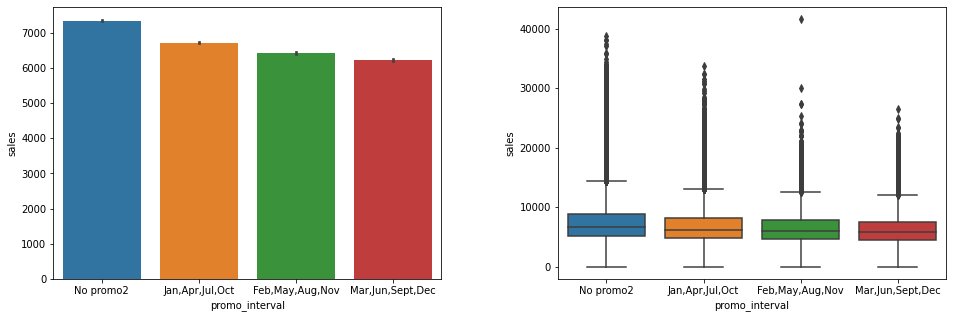

In [66]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['promo_interval'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['promo_interval'],y=dados['sales'])

plt.show()

In [69]:
# Descriptive Analysis
dados.groupby('promo_interval').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo_interval,,,,,,,,
"Feb,May,Aug,Nov",48909.0,6428.581795,2581.904356,0.0,4599.0,6015.0,7802.0,41551.0
"Jan,Apr,Jul,Oct",121112.0,6716.844821,2815.576865,0.0,4784.0,6206.0,8084.0,33668.0
"Mar,Jun,Sept,Dec",40327.0,6221.611650,2586.556356,0.0,4419.5,5754.0,7496.0,26485.0
No promo2,211763.0,7352.293512,3404.783325,0.0,5085.0,6687.0,8825.0,38722.0


### H18: Quanto mais antiga a promo2, menos a loja vende

This hypothesis is **True**

A relação é bem fraca, mas ainda existente, ela diz que quanto mais velha, mais se vende e quanto mais nova menos se vende.

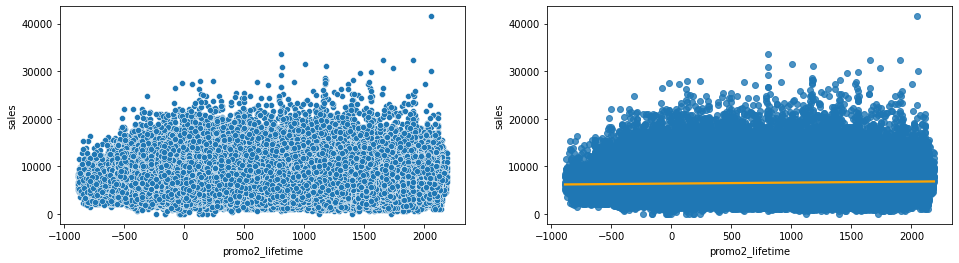

In [70]:
df_aux = dados[dados['promo2']==1] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['promo2_lifetime'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['promo2_lifetime'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [71]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['promo2_lifetime','sales']))

Coeficiente de Correlação de Pearson: 0.04906081652150282


## 2.3 Multivariate Analysis

Store type e assortment são a mesma coisa (multivariate analysis)

As competições atuais são cada vez mais perto (multivariate analysis)

e claro, melhorar as análises em geral e enxutar o que for preciso!

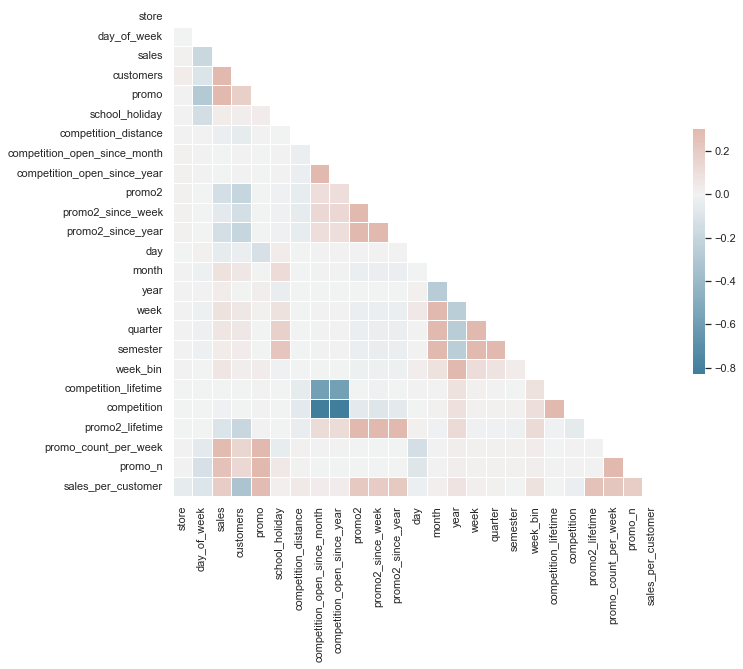

In [85]:
# Using seaborn diagonal correlation matrix: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set_theme(style="white")

# Compute the correlation matrix
corr = dados.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# 3.0 Data Preprocessing

## 3.1 Normalization

In [46]:
# Apparently there's no normal distributed features

## 3.2 Encoding

In [47]:
## One Hot Encoding (state_holiday)
dados['easter'] = dados['state_holiday'].apply(lambda x: 1 if x=='Easter holiday' else 0)
dados['public_holiday'] = dados['state_holiday'].apply(lambda x: 1 if x=='public holiday' else 0)
dados['christmas'] = dados['state_holiday'].apply(lambda x: 1 if x=='Christmas' else 0)
dados.drop('state_holiday',1,inplace=True)

## Label Encoding (store_type)
le = LabelEncoder()
dados['store_type'] = le.fit_transform(dados[['store_type']])
pickle.dump(le,open('/Users/nando/Comunidade DS/ds_em_producao/deploy/store_type_label_encoder.pickle','wb'))

## Ordinal Encoding (assortment, season)
dados['assortment'] = dados['assortment'].map({'basic':0,'extended':1,'extra':2})
dados['season'] = dados['season'].map({'winter':1,'spring':2,'summer':3,'autumn':4})

## Target Encoding (promo_interval)
te = TargetEncoder()
dados['promo_interval'] = te.fit_transform(dados['promo_interval'],y=dados['sales'])
pickle.dump(te,open('/Users/nando/Comunidade DS/ds_em_producao/deploy/promo_interval_target_encoder.pickle','wb'))

## Cyclic Encoding (day_of_week, competition_open_since_month, promo2_since_week, day, month, week, quarter, semester, season)
dados['day_of_week_sin'] = dados['day_of_week'].apply(lambda x: np.sin(2*np.pi*x/7))
dados['day_of_week_cos'] = dados['day_of_week'].apply(lambda x: np.cos(2*np.pi*x/7))
dados.drop('day_of_week',1,inplace=True)

dados['competition_open_since_month_sin'] = dados['competition_open_since_month'].apply(lambda x: np.sin(2*np.pi*x/12))
dados['competition_open_since_month_cos'] = dados['competition_open_since_month'].apply(lambda x: np.cos(2*np.pi*x/12))
dados.drop('competition_open_since_month',1,inplace=True)

dados['promo2_since_week_sin'] = dados['promo2_since_week'].apply(lambda x: np.sin(2*np.pi*x/52))
dados['promo2_since_week_cos'] = dados['promo2_since_week'].apply(lambda x: np.cos(2*np.pi*x/52))
dados.drop('promo2_since_week',1,inplace=True)

dados['day_sin'] = dados['day'].apply(lambda x: np.sin(2*np.pi*x/30))
dados['day_cos'] = dados['day'].apply(lambda x: np.cos(2*np.pi*x/30))
dados.drop('day',1,inplace=True)

dados['month_sin'] = dados['month'].apply(lambda x: np.sin(2*np.pi*x/12))
dados['month_cos'] = dados['month'].apply(lambda x: np.cos(2*np.pi*x/12))
dados.drop('month',1,inplace=True)

dados['week_sin'] = dados['week'].apply(lambda x: np.sin(2*np.pi*x/52))
dados['week_cos'] = dados['week'].apply(lambda x: np.cos(2*np.pi*x/52))
dados.drop('week',1,inplace=True)

dados['quarter_sin'] = dados['quarter'].apply(lambda x: np.sin(2*np.pi*x/4))
dados['quarter_cos'] = dados['quarter'].apply(lambda x: np.cos(2*np.pi*x/4))
dados.drop('quarter',1,inplace=True)

dados['semester_sin'] = dados['semester'].apply(lambda x: np.sin(2*np.pi*x/2))
dados['semester_cos'] = dados['semester'].apply(lambda x: np.cos(2*np.pi*x/2))
dados.drop('semester',1,inplace=True)

dados['season_sin'] = dados['season'].apply(lambda x: np.sin(2*np.pi*x/4))
dados['season_cos'] = dados['season'].apply(lambda x: np.cos(2*np.pi*x/4))
dados.drop('season',1,inplace=True)

## 3.3 Rescaling

In [48]:
## Min Max Scaler (store,week_bin, promo_count_per_week, promo_n, year, store_type, assortment, promo_interval, day_of_week_sin/cos, competition_open_since_month_sin/cos, promo2_since_week_sin/cos, day_sin/cos, month_sin/cos, week_sin/cos, quarter_sin/cos, semester_sin/cos, season_sin/cos)

mms_columns_lst = ['store','week_bin', 'promo_count_per_week', 'promo_n', 'year', 'store_type', 'assortment',
'promo_interval', 'day_of_week_sin','day_of_week_cos', 'competition_open_since_month_sin',
'competition_open_since_month_cos', 'promo2_since_week_sin','promo2_since_week_cos', 
'day_sin','day_cos', 'month_sin','month_cos', 'week_sin','week_cos', 'quarter_sin',
'quarter_cos', 'semester_sin','semester_cos', 'season_sin','season_cos']

mms = MinMaxScaler()
dados[mms_columns_lst] = mms.fit_transform(dados[mms_columns_lst])
pickle.dump(mms,open('/Users/nando/Comunidade DS/ds_em_producao/deploy/min_max_scaler.pickle','wb'))

## Robust Scaler (competition_distance, competition_open_since_year, promo2_since_year, competition_lifetime, promo2_lifetime)

rs_columns_lst = ['competition_distance', 'competition_open_since_year', 'promo2_since_year',
                  'competition_lifetime', 'promo2_lifetime']

rs = RobustScaler()
dados[rs_columns_lst] = rs.fit_transform(dados[rs_columns_lst])
pickle.dump(rs,open('/Users/nando/Comunidade DS/ds_em_producao/deploy/robust_scaler.pickle','wb'))

## 3.4 Target Transformation

In [49]:
## Log Transformation (sales)
dados['sales'] = np.log1p(dados['sales'])

## Exporting Dataset (After Data Preprocessing)

In [42]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_preprocessing.csv',index=False)

# 4.0 Feature Selection

## Importing Dataset

In [70]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_preprocessing.csv')

## 4.1 Preparing for Feature Selection

In [11]:
# Por ser uma timeseries, para evitar overfit, vou separar as 12 últimas semanas para test e o resto para train
dados['date'] = pd.to_datetime(dados['date'])
train = dados[dados['date']<dados['date'].max()-datetime.timedelta(12*7)]
test = dados[dados['date']>=dados['date'].max()-datetime.timedelta(12*7)]

# Adapting for boruta algorithm (i'll use train set)
x_train_bor = np.array(train.drop('sales',1).drop('date',1))
y_train_bor = np.array(train['sales'])

## 4.2 Using Boruta as a Feature Selector

### 4.2.1 Fitting Boruta

In [87]:
boruta = BorutaPy(RandomForestRegressor(n_jobs=-1),n_estimators='auto',verbose=2, random_state=101)
boruta.fit(x_train_bor,y_train_bor)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	21
Tentative: 	1
Reject

BorutaPy(estimator=RandomForestRegressor(n_estimators=66, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x15E299940),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x15E299940,
         verbose=2)

Escolheu 21 variáveis como mais importantes e rejeitou 16, ficou sem saber em apenas uma.

### 4.2.2 Get It's Results

In [102]:
# Columns selected
train.drop(['sales','date'],1).columns[boruta.support_].to_list()

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2_since_year',
 'promo_interval',
 'week_bin',
 'competition_lifetime',
 'promo2_lifetime',
 'promo_n',
 'day_of_week_sin',
 'day_of_week_cos',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos',
 'day_sin',
 'day_cos',
 'month_cos']

In [101]:
# Columns not selected
train.drop(['sales','date'],1).columns[~boruta.support_].to_list()

['school_holiday',
 'promo2',
 'year',
 'competition',
 'promo_count_per_week',
 'easter',
 'public_holiday',
 'christmas',
 'month_sin',
 'week_sin',
 'week_cos',
 'quarter_sin',
 'quarter_cos',
 'semester_sin',
 'semester_cos',
 'season_sin',
 'season_cos']

In [113]:
# Let's compare with what we saw in EDA
print(tabulate(table,headers='firstrow'))

  Hypothesis  Feature                       Result      Relevance
------------  ----------------------------  ----------  -----------
           1  Day                           True        High
           2  Year                          True        Low
           3  Day of Week                   False       High
           4  State Holiday/Public Holiday  True/False  High/Low
           5  Semester                      True        Low
           6  Quarter                       False       Low
           7  Season                        False       Low
           8  Competition                   True        Low
           9  Competition Distance          False       Low
          10  Competition Lifetime          False       Low
          11  Store Type                    True        High
          12  Assortment                    True        High
          13  Promo                         True        High
          14  Promo_n                       True        Low
          15  Pr

Temos diferenças e semelhanças, mas quase todas as variáveis que dissemos ter alta relevância de fato demonstraram essa relevância.

O algoritmo adicionou algumas features que não tinhamos apontado como relevantes.

In [139]:
# Rank of Features
for c in range(train.drop(['sales','date'],1).columns.shape[0]):
    rank = boruta.ranking_[c]
    feature = train.drop(['sales','date'],1).columns.values[c]
    print(f'{feature} - Rank: {rank}º')

store - Rank: 1º
promo - Rank: 1º
school_holiday - Rank: 11º
store_type - Rank: 1º
assortment - Rank: 1º
competition_distance - Rank: 1º
competition_open_since_year - Rank: 1º
promo2 - Rank: 6º
promo2_since_year - Rank: 1º
promo_interval - Rank: 1º
year - Rank: 13º
week_bin - Rank: 1º
competition_lifetime - Rank: 1º
competition - Rank: 14º
promo2_lifetime - Rank: 1º
promo_count_per_week - Rank: 4º
promo_n - Rank: 1º
easter - Rank: 15º
public_holiday - Rank: 12º
christmas - Rank: 17º
day_of_week_sin - Rank: 1º
day_of_week_cos - Rank: 1º
competition_open_since_month_sin - Rank: 1º
competition_open_since_month_cos - Rank: 1º
promo2_since_week_sin - Rank: 1º
promo2_since_week_cos - Rank: 1º
day_sin - Rank: 1º
day_cos - Rank: 1º
month_sin - Rank: 5º
month_cos - Rank: 1º
week_sin - Rank: 3º
week_cos - Rank: 2º
quarter_sin - Rank: 8º
quarter_cos - Rank: 7º
semester_sin - Rank: 18º
semester_cos - Rank: 16º
season_sin - Rank: 9º
season_cos - Rank: 10º


## 4.3 Select Features

In [ ]:
# Essa é a lista que usarei baseado no boruta e na EDA
cols_selected = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'promo_interval',
 'competition_lifetime',
 'promo2_lifetime',
 'promo_n',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos']

Adicionei o month_sin, pois ele selecionou o cos e o sin ficou bem colocado.

Removi promo2 since year, promo2 since week por achar que o promo2_lifetime traz a mesma informação em menos dimensionalidade, sendo ele também selecionado pelo algorítmo, apesar de não ter nos chamado a atenção na EDA.

Removi competition_open_since_year, competition_open_since_month por achar que o competition_lifetime traz a mesma informação em menos dimensionalidade, sendo ele também selecionado pelo algorítmo, apesar de não ter nos chamado a atenção na EDA.

## 4.4 Organize the Data for Model Evaluation

In [12]:
# Organize the entries for model evaluation with cross validation
# remember that we have to sort the values by date for a time series cv!

cols_selected = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'promo_interval',
 'competition_lifetime',
 'promo2_lifetime',
 'promo_n',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'sales', # need to add sales to get y values
 'date'] # we need to add date to sort values

# Train val datasets
df_aux = train[cols_selected].sort_values('date').drop('date',1).reset_index(drop=True)
x_train_val = df_aux.drop('sales',1)
y_train_val = df_aux['sales']

# Test datasets
df_aux = test[cols_selected].sort_values('date').drop('date',1).reset_index(drop=True)
x_test = df_aux.drop('sales',1)
y_test = df_aux['sales']

## Export Datasets (Train_Val and Test)

In [13]:
x_train_val.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_train_val.csv',index=False)
y_train_val.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_train_val.csv',index=False)
x_test.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_test.csv',index=False)
y_test.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_test.csv',index=False)

# 5.0 Machine Learning

## Import Datasets (Train_Val and Test)

In [8]:
x_train_val = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_train_val.csv')
y_train_val = np.ravel(pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_train_val.csv'))
x_test = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_test.csv')
y_test = np.ravel(pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_test.csv'))

In [9]:
# Expm1 (Reverter a log transformation, pois vamos fazer cv e precisamos fazer atraves de um método do sklearn)
y_train_val = np.expm1(y_train_val)
y_test = np.expm1(y_test)

In [10]:
# Train and test datasets
train_val = pd.merge(left=x_train_val,right=pd.DataFrame(y_train_val),right_index=True,left_index=True).rename(columns={0:'sales'})
test = pd.merge(left=x_test,right=pd.DataFrame(y_test),right_index=True,left_index=True).rename(columns={0:'sales'})

In [48]:
# Regression report using cross_validation in timeseries
def reg_cv(regressor):
    model = TransformedTargetRegressor(regressor,func=np.log1p,inverse_func=np.expm1)
    neg_rmse = (cross_val_score(model,x_train_val,y_train_val,n_jobs=-1,cv=TimeSeriesSplit(n_splits=5),scoring='neg_root_mean_squared_error'))
    neg_mse = cross_val_score(model,x_train_val,y_train_val,n_jobs=-1,cv=TimeSeriesSplit(n_splits=5),scoring='neg_mean_squared_error')
    neg_mae = cross_val_score(model,x_train_val,y_train_val,n_jobs=-1,cv=TimeSeriesSplit(n_splits=5),scoring='neg_mean_absolute_error')
    
    mean_rmse = round(neg_rmse.mean(),3)
    std_rmse = round(neg_rmse.std(),3)
    
    mean_mse = round(neg_mse.mean(),3)
    std_mse = round(neg_mse.std(),3)
    
    mean_mae = round(neg_mae.mean(),3)
    std_mae = round(neg_mae.std(),3)
    
    return print( tabulate( [ ['RMSE','MSE','MAE'],[f'{mean_rmse} +/- ({std_rmse})',f'{mean_mse} +/- ({std_mse})',f'{mean_mae} +/- ({std_mae})'] ] ) )

## 5.1 Baseline Model (Average)

In [154]:
# Predict (get the average) of each store sales on train_val set
sales_average_by_store = train_val.groupby('store').mean()['sales']

# Merge (to compare) the predictions with real values in test set
df_merge = pd.merge(test,sales_average_by_store,on='store',suffixes=('_true','_pred')) 

# Get these values
y_true = df_merge['sales_true']
y_pred = df_merge['sales_pred']

# Analyse the Metrics

rmse = np.sqrt(mean_squared_error(y_true,y_pred))
mse = mean_squared_error(y_true,y_pred)
mae = mean_absolute_error(y_true,y_pred)

print( tabulate( [ ['RMSE','MSE','MAE'],[rmse,mse,mae] ] ) )

------------------  ------------------  ------------------
RMSE                MSE                 MAE
1888.8262193220176  3567664.4867983065  1403.0730699159003
------------------  ------------------  ------------------


Esse resultado será nossa base de comparação para os modelos de ML.

## 5.2 Linear Regression

In [7]:
reg_cv(LinearRegression())

-----------------------  ------------------------------  -----------------------
RMSE                     MSE                             MAE
-2884.187 +/- (228.534)  -8370760.366 +/- (1361470.241)  -1993.464 +/- (111.837)
-----------------------  ------------------------------  -----------------------


Ok, esse resultado foi pior que o modelo baseline, então precisamos de modelos mais complexos!

## 5.3 Lasso

In [8]:
reg_cv(Lasso())

-----------------------  ------------------------------  ----------------------
RMSE                     MSE                             MAE
-3221.943 +/- (161.901)  -10407129.59 +/- (1052450.235)  -2256.946 +/- (82.538)
-----------------------  ------------------------------  ----------------------


Esse resultado confirma a informação levantada na linear regression!

## 5.4 Random Forest Regressor

In [9]:
reg_cv(RandomForestRegressor(n_jobs=-1,random_state=101))

-----------------------  -----------------------------  -----------------------
RMSE                     MSE                            MAE
-1771.367 +/- (232.375)  -3191739.984 +/- (875947.079)  -1139.758 +/- (140.194)
-----------------------  -----------------------------  -----------------------


## 5.5 XGBoost Regressor

In [10]:
reg_cv(XGBRegressor(n_jobs=-1,random_state=101,objective='reg:squarederror'))

-----------------------  ------------------------------  -----------------------
RMSE                     MSE                             MAE
-1690.567 +/- (289.505)  -2941831.049 +/- (1086557.649)  -1150.861 +/- (151.164)
-----------------------  ------------------------------  -----------------------


De fato esses modelos performaram melhor!

Random forest e XGBoost tem performaces parecidas, mas o XGBoost é relativamente maior.

Vamos continuar, então, com o XGBoost para o finetuning.

# 6.0 Hyperparameter Fine Tuning

## 6.1 RandomizedSearchCV

In [110]:
# Vamos utilizar random search por conta do baixo custo computacional (considerando que estamos no 1º ciclo)

p_grid = {'n_estimators':[100,200,300],'max_depth':[3,6,9,12],'min_samples_split':[2,4,8,10,12],'min_samples_leaf':[2,4,8,10,12]}
regressor = RandomForestRegressor(n_jobs=-1,random_state=101)

rs = RandomizedSearchCV(regressor,p_grid,cv=TimeSeriesSplit(n_splits=5),n_iter=10,scoring='neg_mean_squared_error')
rs.fit(x_train_val,y_train_val)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=101),
                   param_distributions={'max_depth': [3, 6, 9, 12],
                                        'min_samples_leaf': [2, 4, 8, 10, 12],
                                        'min_samples_split': [2, 4, 8, 10, 12],
                                        'n_estimators': [100, 200, 300]},
                   scoring='neg_mean_squared_error')

In [112]:
# See the results
pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,10.758177,5.225026,0.101824,0.001433,300,10,10,12,"{'n_estimators': 300, 'min_samples_split': 10,...",-4.756722e+06,-6.290277e+06,-4.591417e+06,-4.513319e+06,-4.941286e+06,-5.018604e+06,652612.411963,1
4,2.803848,1.288153,0.032190,0.002314,100,2,4,9,"{'n_estimators': 100, 'min_samples_split': 2, ...",-5.277480e+06,-7.318582e+06,-5.683820e+06,-5.560309e+06,-6.040903e+06,-5.976219e+06,714540.150320,2
6,8.581464,4.360225,0.101696,0.031916,300,4,10,9,"{'n_estimators': 300, 'min_samples_split': 4, ...",-5.402162e+06,-7.372579e+06,-5.709445e+06,-5.590076e+06,-6.060592e+06,-6.026971e+06,706240.173168,3
2,5.373144,2.892684,0.057764,0.002137,200,4,10,9,"{'n_estimators': 200, 'min_samples_split': 4, ...",-5.403786e+06,-7.371250e+06,-5.708782e+06,-5.598574e+06,-6.069825e+06,-6.030444e+06,704555.373285,4
7,8.750343,4.141175,0.083703,0.002878,300,2,12,9,"{'n_estimators': 300, 'min_samples_split': 2, ...",-5.433716e+06,-7.395388e+06,-5.712190e+06,-5.592800e+06,-6.078579e+06,-6.042535e+06,709021.895941,5
0,1.800733,0.792964,0.054342,0.053046,100,2,4,6,"{'n_estimators': 100, 'min_samples_split': 2, ...",-6.260394e+06,-8.611577e+06,-6.826745e+06,-6.698720e+06,-7.136261e+06,-7.106739e+06,803316.256022,6
5,3.894527,1.783281,0.048734,0.000925,200,4,10,6,"{'n_estimators': 200, 'min_samples_split': 4, ...",-6.296888e+06,-8.606792e+06,-6.833477e+06,-6.707774e+06,-7.147109e+06,-7.118408e+06,792566.897821,7
8,2.193815,0.974155,0.032738,0.000799,200,12,8,3,"{'n_estimators': 200, 'min_samples_split': 12,...",-6.899746e+06,-9.402885e+06,-7.476565e+06,-7.498193e+06,-8.248708e+06,-7.905219e+06,862714.356071,8
1,1.929907,0.823414,0.033257,0.001078,200,8,10,3,"{'n_estimators': 200, 'min_samples_split': 8, ...",-6.909917e+06,-9.403654e+06,-7.476565e+06,-7.498193e+06,-8.248708e+06,-7.907407e+06,860617.224526,9
3,2.222097,1.004581,0.032403,0.001727,200,4,12,3,"{'n_estimators': 200, 'min_samples_split': 4, ...",-6.909837e+06,-9.407758e+06,-7.476565e+06,-7.498193e+06,-8.248708e+06,-7.908212e+06,862063.021273,10


## 6.2 Model Evaluation

In [123]:
# I'll use only a test set, im not doing any kind of cv for now

estimator = rs.best_estimator_

y_pred = estimator.predict(x_test)
y_true = y_test

rmse = np.sqrt(mean_squared_error(y_true,y_pred)) 
mse = mean_squared_error(y_true,y_pred)
mae = mean_absolute_error(y_true,y_pred)

print( tabulate( [ ['RMSE','MSE','MAE'],[rmse,mse,mae] ] ) )

-----------------  -----------------  -----------------
RMSE               MSE                MAE
2091.866390005335  4375904.993633952  1504.884719991698
-----------------  -----------------  -----------------


So bad!

# 7.0 Error Interpretation

In [49]:
best_estimator = XGBRegressor(n_jobs=-1,random_state=101,objective='reg:squarederror').fit(x_train_val,y_train_val)

## 8.1 Business Performace

### 8.1.1 Our model predictions

In [181]:
lst = []
new_df = []
for store in test['store'].unique():
    y_pred = pd.Series(best_estimator.predict(x_test))
    df = pd.concat([test,y_pred],axis=1).rename(columns={0:'sales_pred'})[['store','sales','sales_pred']].query(f'store=={store}')

    df['error'] = np.abs(df['sales']-df['sales_pred'])
    df['worst_scenario'] = df['sales_pred']-mean_absolute_error(df['sales'],df['sales_pred'])
    df['best_scenario'] = df['sales_pred']+mean_absolute_error(df['sales'],df['sales_pred'])

    worst_scenario_for_all_6_weeks = df['worst_scenario'].sum()
    best_scenario_for_all_6_weeks = df['best_scenario'].sum()
    predictions_for_all_6_weeks = df['sales_pred'].sum()
    sales_for_all_6_weeks = df['sales'].sum()
    
    lst = [store,sales_for_all_6_weeks,predictions_for_all_6_weeks,worst_scenario_for_all_6_weeks,best_scenario_for_all_6_weeks]
    
    new_df.append(lst.copy())
    
df = pd.DataFrame(new_df,columns=['store','sales','sales_pred','worst_scenario','best_scenario'])
df

,store,sales,sales_pred,worst_scenario,best_scenario
0,0.719928,99129.0,86121.117188,73012.828125,99229.406250
1,0.210952,130079.0,110807.359375,90652.781250,130961.937500
2,0.399461,100386.0,107522.304688,94044.343750,121000.265625
3,0.067325,115509.0,101069.859375,86630.718750,115509.000000
4,0.309695,110091.0,104019.343750,94812.796875,113225.875000
...,...,...,...,...,...
1110,0.166966,82510.0,91728.093750,80512.562500,102943.632812
1111,0.263914,50344.0,46446.683594,40812.339844,52081.027344
1112,0.994614,35584.0,34994.492188,30794.169922,39194.820312
1113,0.354578,81890.0,82000.945312,77377.445312,86624.429688


In [182]:
# Ver o quão confiável são os cenários
df['worst_scenario_error'] = df['sales'] - df['worst_scenario'] 
df['best_scenario_error'] = df['sales'] - df['best_scenario'] 

best_scenario_superestima_media = round(df[df['best_scenario_error']<0]['best_scenario_error'].mean(),3)
best_scenario_superestima_std = round(df[df['best_scenario_error']<0]['best_scenario_error'].std(),3)
show_best_scenario_superestima = f'{best_scenario_superestima_media} +/- ({best_scenario_superestima_std})'

best_scenario_subestima_media = round(df[df['best_scenario_error']>0]['best_scenario_error'].mean(),3)
best_scenario_subestima_std = round(df[df['best_scenario_error']>0]['best_scenario_error'].std(),3)
show_best_scenario_subestima = f'{best_scenario_subestima_media} +/- ({best_scenario_subestima_std})'

worst_scenario_superestima_media = round(df[df['worst_scenario_error']<0]['worst_scenario_error'].mean(),3)
worst_scenario_superestima_std = round(df[df['worst_scenario_error']<0]['worst_scenario_error'].std(),3)
show_worst_scenario_superstima = f'{worst_scenario_superestima_media} +/- ({worst_scenario_superestima_std})'

worst_scenario_subestima_media = round(df[df['worst_scenario_error']>0]['worst_scenario_error'].mean(),3)
worst_scenario_subestima_std = round(df[df['worst_scenario_error']>0]['worst_scenario_error'].std(),3)
show_worst_scenario_subestima = f'{worst_scenario_subestima_media} +/- ({worst_scenario_subestima_std})'

tab = [ ['Scenario','Superestima','Subestima'],['Best',show_best_scenario_superestima,show_best_scenario_subestima],['Worst',show_worst_scenario_superstima,show_worst_scenario_subestima] ]
print(tabulate(tab,headers='firstrow'))

Scenario    Superestima                 Subestima
----------  --------------------------  ------------------------
Best        -12379.668 +/- (11974.086)  0.002 +/- (0.004)
Worst       -0.003 +/- (0.003)          18058.51 +/- (19577.151)


### 8.1.2 Compare these predictions with the baseline model

In [183]:
# Erro por loja (MAE e MAPE)

y_pred = pd.Series(best_estimator.predict(x_test))
df_aux = pd.concat([test,y_pred],axis=1).rename(columns={0:'sales_pred'})[['store','sales','sales_pred']]
df_aux['error'] = df_aux['sales']-df_aux['sales_pred']

mape_store = round(mean_absolute_percentage_error(df['sales'],df['sales_pred']),3)
mae_store = round(mean_absolute_error(df['sales'],df['sales_pred']),3)

tab = [['MAE','MAPE'],[mae_store,str(mape_store*100)+'%']]
print(tabulate(tab,headers='firstrow'))

    MAE  MAPE
-------  ------
9919.34  9.9%


Nosso erro é em média de 10 mil, que corresponde aproximadamente à 10% do valor predito.

In [184]:
# Vamos supor que a empresa utilizasse o modelo de média antes
pred = train_val.groupby('store').mean()['sales'].reset_index().rename(columns={'sales':'sales_pred'})
true = test[['store','sales']].rename(columns={'sales':'sales_true'})
df = pd.merge(true,pred,on='store')
df = df.groupby('store').sum().reset_index()

mape_store = round(mean_absolute_percentage_error(df['sales_true'],df['sales_pred']),3)
mae_store = round(mean_absolute_error(df['sales_true'],df['sales_pred']),3)

tab = [['Condition','MAE','MAPE'],['Store',mae_store,str(mape_store*100)+'%']]
print(tabulate(tab,headers='firstrow'))

Condition       MAE  MAPE
-----------  ------  ------
Store        8042.6  8.0%


Nosso modelo é pior do que se usássemos a média dos últimos tempos por loja a cada dia. Precisamos melhorar!

## 8.2 Análise de Resíduo

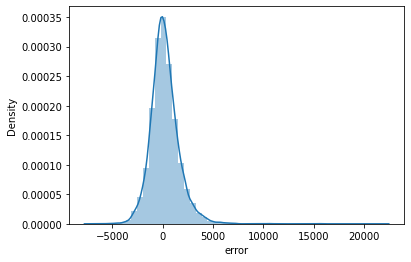

In [185]:
# Distribuição do resíduo
sns.distplot(df_aux['error']);

Segue uma distribuição parecida com a normal, o que é ótimo.

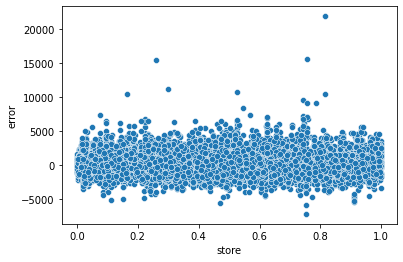

In [186]:
# Scatter dos erros
sns.scatterplot(df_aux['store'],df_aux['error']);

Segue a distribuição esperada. Vemos alguns outliers, mas o comportamento geral é aquele essencial.

# 8.0 Deploy Model in Production

## 8.1 Export Model

In [74]:
# Vamos exportar nosso modelo final que irá ser colocado em produção
cols_selected = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'promo_interval',
 'competition_lifetime',
 'promo2_lifetime',
 'promo_n',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'sales']

x = dados[cols_selected].drop('sales',1)
y = dados[cols_selected]['sales']

model = XGBRegressor(n_jobs=-1,random_state=101,objective='reg:squarederror').fit(x,y) # train with the whole dataset
pickle.dump(model,open('/Users/nando/Comunidade DS/ds_em_producao/deploy/model.pickle','wb'))

## 8.2 Data Modeling and Predict Class

In [262]:
# Vamos criar uma classe que contenha todos os passos que modelam e preparam os dados para o algoritmo entender

import pandas as pd
import numpy as np
import inflection
import datetime
import pickle

initial_data = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/inital_data.csv') # i will use later

class rossmann(object):
    
    def __init__(self):
        self.store_type_label_encoder = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/store_type_label_encoder.pickle','rb'))
        self.promo_interval_target_encoder = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/promo_interval_target_encoder.pickle','rb'))
        self.min_max_scaler = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/min_max_scaler.pickle','rb'))
        self.robust_scaler = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/robust_scaler.pickle','rb'))

    def data_cleaning(self,dados):
        ## 1.1 Rename Columns and Values

        # CamelCase to snake_case
        for c in range(len(dados.columns)):
            dados.rename(columns={dados.columns.values[c]:inflection.underscore(dados.columns.values[c])},inplace=True)

        dados['state_holiday'] = dados['state_holiday'].map({'a':'public holiday', 'b':'Easter holiday', 'c':'Christmas', '0':'None'})
        dados['assortment'] = dados['assortment'].map({'a':'basic','b':'extra','c':'extended'})

        ## 1.3 Data Types

        # date to datetime64
        dados['date'] = pd.to_datetime(dados['date'])

        ### 1.4 Dealing With NAN

        ## competition_distance, competition_open_since_month, competition_open_since_year
        # I suppose that the competition_distance == nan refers that there's no competition!
        for index in dados[dados['competition_distance'].isna()].index:
            dados.loc[index,'competition_distance'] = 999999 # High values suggests that the competitors are so far that there's no competition
            dados.loc[index,'competition_open_since_month'] = 0 # It suggets that it has never been opened
            dados.loc[index,'competition_open_since_year'] = 0 # It suggets that it has never been opened

        ## competition_open_since_month, competition_open_since_year
        # I suppose that if there's no year, there's no month and vice-versa
        month_median = round(initial_data['CompetitionOpenSinceMonth'].median(),0) # get the median of the whole dataset
        year_median = round(initial_data['CompetitionOpenSinceYear'].median(),0) # get the median of the whole dataset
        for index in dados[dados['competition_open_since_month'].isna()].index:
            dados.loc[index,'competition_open_since_month'] = month_median # Im gonna use median and round to have discret values
            dados.loc[index,'competition_open_since_year'] = year_median # Im gonna use median and round to have discret values

        ## promo_interval, promo2_since_week, promo2_since_year
        # Because if there's no promo2, theres no since date or interval
        for index in dados[dados['promo2_since_week'].isna()].index:
            dados.loc[index, 'promo2_since_week'] = 0 # It suggets that there's no promo2 week start
            dados.loc[index, 'promo2_since_year'] = 0 # It suggets that there's no promo2 year start
            dados.loc[index, 'promo_interval'] = 'No promo2' # For now, im going to substitute with this

        ## 1.5 Data Types (after NaN)

        # float to int in columns related to dates
        dados['competition_open_since_month'] = dados['competition_open_since_month'].astype(int)
        dados['competition_open_since_year'] = dados['competition_open_since_year'].astype(int)
        dados['promo2_since_week'] = dados['promo2_since_week'].astype(int)
        dados['promo2_since_year'] = dados['promo2_since_year'].astype(int)
        
        return dados
    
    def feature_engineering(self,dados):
        # Day, Month, Week and Year Variables
        dados['day'] = pd.to_datetime(dados['date']).dt.day
        dados['month'] = pd.to_datetime(dados['date']).dt.month
        dados['year'] = pd.to_datetime(dados['date']).dt.year
        dados['week'] = pd.to_datetime(dados['date']).dt.week

        # Semester and Quarter
        dados['quarter'] = pd.to_datetime(dados['date']).dt.quarter
        dados['semester'] = pd.to_datetime(dados['date']).dt.quarter.apply(lambda x: 1 if x == 1 or x == 2 else 2)

        # Season
        def season_of_date(date):
            year = str(date.year)
            seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
                       'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
                       'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
            if date in seasons['spring']:
                return 'spring'
            if date in seasons['summer']:
                return 'summer'
            if date in seasons['autumn']:
                return 'autumn'
            else:
                return 'winter'
        dados['season'] = pd.to_datetime(dados['date']).map(season_of_date)

        # Weeks for timeseries analyses
        dados['week_bin'] = np.nan
        for index in dados.index:
            if dados.loc[index,'year']==2013:
                dados.loc[index,'week_bin'] = dados.loc[index,'week']
            if dados.loc[index,'year']==2014:
                dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 52
            if dados.loc[index,'year']==2015:
                dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 104
        dados['week_bin'] = dados['week_bin'].astype('int')

        # Competition Lifetime
        dados['competition_lifetime'] = np.nan
        for index in dados.index:
            try:
                data = datetime.datetime(dados.loc[index,'competition_open_since_year'],dados.loc[index,'competition_open_since_month'],1)
                dados.loc[index, 'competition_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - data).days

            except:
                dados.loc[index,'competition_lifetime'] = -999 # Never opened
        dados['competition_lifetime'] = dados['competition_lifetime'].astype('int')

        # Competition
        dados['competition'] = dados['competition_lifetime'].apply(lambda x: 0 if x<0 else 1) # Negative values suggests that this competition has never been started yet or we don't even have competitors (we chose -999 above)

        # Promo2 Lifetime
        dados['promo2_lifetime'] = np.nan
        for index in dados.index:
            if dados.loc[index,'promo_interval'] != 'No promo2':
                year = dados.loc[index,'promo2_since_year']
                week = dados.loc[index,'promo2_since_week']
                date = "{}-W{}".format(year,week)
                date_datetime = datetime.datetime.strptime(date + '-1', "%Y-W%W-%w")
                dados.loc[index,'promo2_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - date_datetime).days
            else:
                dados.loc[index,'promo2_lifetime'] = -999
        dados['promo2_lifetime'] = dados['promo2_lifetime'].astype(int)

        # Promo Count per Week
        dados['promo_count_per_week'] = np.nan
        for index in dados.index:
            week = dados.loc[index,'week_bin']
            store = dados.loc[index,'store']
            try:
                dados.loc[index,'promo_count_per_week'] = dados[dados['store']==store].groupby('week_bin').sum()['promo'][week]
            except:
                dados.loc[index,'promo_count_per_week'] = 0
        dados['promo_count_per_week'] = dados['promo_count_per_week'].astype('int')

        # Enumerate per week each store promotion
        dados['promo_n'] = np.nan
        for c in dados.index:
            if dados.loc[c,'promo_count_per_week']>0: # os que tem promoção na semana: Enumerate the promotion per store on each week
                week = dados.loc[c,'week_bin']
                store = dados.loc[c,'store']
                df_aux = pd.DataFrame(dados[(dados['store']==store)&(dados['week_bin']==week)].sort_values(by='date')['promo'])[dados['promo']==1].reset_index().reset_index().set_index('index')
                df_aux['level_0'] = df_aux['level_0'] + 1
                for index in df_aux.index:
                    dados.loc[index,'promo_n'] = df_aux.loc[index,'level_0']
            elif dados.loc[c,'promo_count_per_week']==0: # os que não tem promoção na semana: iguala a 0
                dados.loc[c,'promo_n'] = 0
        dados['promo_n'].fillna(-1,inplace=True) # São dias sem promoção em semanas com promoção: iguala a -1
        dados['promo_n'] = dados['promo_n'].astype('int')
        
        return dados
    
    def data_preprocessing(self,dados):
        ## 3.2 Encoding

        ## One Hot Encoding (state_holiday)
        dados['easter'] = dados['state_holiday'].apply(lambda x: 1 if x=='Easter holiday' else 0)
        dados['public_holiday'] = dados['state_holiday'].apply(lambda x: 1 if x=='public holiday' else 0)
        dados['christmas'] = dados['state_holiday'].apply(lambda x: 1 if x=='Christmas' else 0)
        dados.drop('state_holiday',1,inplace=True)

        ## Label Encoding (store_type)
        dados['store_type'] = self.store_type_label_encoder.transform(dados[['store_type']])

        ## Ordinal Encoding (assortment, season)
        dados['assortment'] = dados['assortment'].map({'basic':0,'extended':1,'extra':2})
        dados['season'] = dados['season'].map({'winter':1,'spring':2,'summer':3,'autumn':4})

        ## Target Encoding (promo_interval)
        dados['promo_interval'] = self.promo_interval_target_encoder.transform(dados['promo_interval'])

        ## Cyclic Encoding (day_of_week, competition_open_since_month, promo2_since_week, day, month, week, quarter, semester, season)
        dados['day_of_week_sin'] = dados['day_of_week'].apply(lambda x: np.sin(2*np.pi*x/7))
        dados['day_of_week_cos'] = dados['day_of_week'].apply(lambda x: np.cos(2*np.pi*x/7))
        dados.drop('day_of_week',1,inplace=True)

        dados['competition_open_since_month_sin'] = dados['competition_open_since_month'].apply(lambda x: np.sin(2*np.pi*x/12))
        dados['competition_open_since_month_cos'] = dados['competition_open_since_month'].apply(lambda x: np.cos(2*np.pi*x/12))
        dados.drop('competition_open_since_month',1,inplace=True)

        dados['promo2_since_week_sin'] = dados['promo2_since_week'].apply(lambda x: np.sin(2*np.pi*x/52))
        dados['promo2_since_week_cos'] = dados['promo2_since_week'].apply(lambda x: np.cos(2*np.pi*x/52))
        dados.drop('promo2_since_week',1,inplace=True)

        dados['day_sin'] = dados['day'].apply(lambda x: np.sin(2*np.pi*x/30))
        dados['day_cos'] = dados['day'].apply(lambda x: np.cos(2*np.pi*x/30))
        dados.drop('day',1,inplace=True)

        dados['month_sin'] = dados['month'].apply(lambda x: np.sin(2*np.pi*x/12))
        dados['month_cos'] = dados['month'].apply(lambda x: np.cos(2*np.pi*x/12))
        dados.drop('month',1,inplace=True)

        dados['week_sin'] = dados['week'].apply(lambda x: np.sin(2*np.pi*x/52))
        dados['week_cos'] = dados['week'].apply(lambda x: np.cos(2*np.pi*x/52))
        dados.drop('week',1,inplace=True)

        dados['quarter_sin'] = dados['quarter'].apply(lambda x: np.sin(2*np.pi*x/4))
        dados['quarter_cos'] = dados['quarter'].apply(lambda x: np.cos(2*np.pi*x/4))
        dados.drop('quarter',1,inplace=True)

        dados['semester_sin'] = dados['semester'].apply(lambda x: np.sin(2*np.pi*x/2))
        dados['semester_cos'] = dados['semester'].apply(lambda x: np.cos(2*np.pi*x/2))
        dados.drop('semester',1,inplace=True)

        dados['season_sin'] = dados['season'].apply(lambda x: np.sin(2*np.pi*x/4))
        dados['season_cos'] = dados['season'].apply(lambda x: np.cos(2*np.pi*x/4))
        dados.drop('season',1,inplace=True)

        ## 3.3 Rescaling

        ## Min Max Scaler (store,week_bin, promo_count_per_week, promo_n, year, store_type, assortment, promo_interval, day_of_week_sin/cos, competition_open_since_month_sin/cos, promo2_since_week_sin/cos, day_sin/cos, month_sin/cos, week_sin/cos, quarter_sin/cos, semester_sin/cos, season_sin/cos)

        mms_columns_lst = ['store','week_bin', 'promo_count_per_week', 'promo_n', 'year', 'store_type', 'assortment',
        'promo_interval', 'day_of_week_sin','day_of_week_cos', 'competition_open_since_month_sin',
        'competition_open_since_month_cos', 'promo2_since_week_sin','promo2_since_week_cos', 
        'day_sin','day_cos', 'month_sin','month_cos', 'week_sin','week_cos', 'quarter_sin',
        'quarter_cos', 'semester_sin','semester_cos', 'season_sin','season_cos']

        dados[mms_columns_lst] = self.min_max_scaler.transform(dados[mms_columns_lst])

        ## Robust Scaler (competition_distance, competition_open_since_year, promo2_since_year, competition_lifetime, promo2_lifetime)

        rs_columns_lst = ['competition_distance', 'competition_open_since_year', 'promo2_since_year',
                          'competition_lifetime', 'promo2_lifetime']

        dados[rs_columns_lst] = self.robust_scaler.transform(dados[rs_columns_lst])

        return dados
    
    def feature_selection(self,dados):
        cols_selected = ['store',
         'promo',
         'store_type',
         'assortment',
         'competition_distance',
         'promo_interval',
         'competition_lifetime',
         'promo2_lifetime',
         'promo_n',
         'day_of_week_sin',
         'day_of_week_cos',
         'day_sin',
         'day_cos',
         'month_sin',
         'month_cos']

        dados = dados[cols_selected]
        
        return dados
    
    def get_prediction( self, model, original_data, input_data ):
        
        pred = model.predict( input_data )
        
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' ) # return a df with the original imput and it's prediction

## 8.3 API Handler

In [291]:
# Vamos criar uma api com o flask para podermos acessar esse modelo de qualquer dispositivo que faça requests

from flask import Flask,request,Response
from Rossmann import rossmann
import pickle
import pandas as pd

pipeline = rossmann()        
model = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/model.pickle', 'rb'))

app = Flask(__name__)

@app.route('/predict',methods=['POST'])
def predict():
    
    json = request.get_json() # Get the data
    
    if json: # Foram de fato passados dados
        if isinstance( json, dict ): # um único exemplo
            df_json = pd.DataFrame( json, index=[0] ) 
        else:
            df_json = pd.DataFrame( json, columns=json[0].keys() ) # múltiplos examplos
        
        # data modeling
        dados = df_json.copy()
        dados = pipeline.data_cleaning(dados)
        dados = pipeline.feature_engineering(dados)
        dados = pipeline.data_preprocessing(dados)
        dados = pipeline.feature_selection(dados)
        
        # predict
        dados_response = pipeline.get_prediction(model,df_json,dados)
        
        return dados_response # retorna um df com os dados sem modeling e a prediction sem modeling também
        
            
    else: # não foram passados os dados
        return Response('{}',status=200,mimetype='application/json') # retorna vazio
    
    
if __name__=='__main__':
    app.run(host='0.0.0.0',port=8080,debug=False)

ImportError: cannot import name 'rossmann' from 'Rossmann' (/Users/nando/Comunidade DS/ds_em_producao/Rossmann.py)

## 8.4 API Tester

In [ ]:
# Precisamos testar nossa API aqui para ver se está tudo funcionando corretamente

### 8.4.1 Get the input

In [12]:
# get the data (from data folder)
test_data = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/test.csv')
test_data = pd.merge(test_data,dados_stores,how='left',on='Store').drop('Id',1)

# choose the stores to predict
test_data = test_data[test_data['Store'].isin([30,22,101,200])]

# filter (o modelo não vai receber esses inputs quando estiver de fato em produção!)
test_data = test_data[test_data['Open']==1] # e eu pressuponho que o consumidor quer calcular vendas da loja enquanto aberta!
test_data.drop('Open',axis=1,inplace=True)

# convert to json (para comunicar com a api)
test_data = test_data.to_json(orient='records')

### 8.4.2 Local Test

In [7]:
import requests

url = 'http://0.0.0.0:8080/predict' # localhost
headers = {'Content-type': 'application/json' }
data = test_data # input

r = requests.post( url=url, data=data, headers=headers ) 
print( 'Status Code {}'.format( r.status_code ) ) # ver se deu certo

Status Code 200


In [8]:
pd.DataFrame(r.json()) # converter a response, que veio em forma de json

,Store,DayOfWeek,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prediction
0,22,4,2015-09-17,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5759.546875
1,30,4,2015-09-17,1,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",4686.000000
2,101,4,2015-09-17,1,0,0,d,c,2440.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6491.229980
3,200,4,2015-09-17,1,0,0,a,a,1650.0,10.0,2000.0,0,NaN,NaN,None,7675.339355
4,22,3,2015-09-16,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5759.546875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,200,1,2015-08-03,1,0,1,a,a,1650.0,10.0,2000.0,0,NaN,NaN,None,11290.367188
159,22,6,2015-08-01,0,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",3554.942383
160,30,6,2015-08-01,0,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",4299.778809
161,101,6,2015-08-01,0,0,0,d,c,2440.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6973.650879


Everything working fine!

### 8.4.3 Cloud Test

In [10]:
import requests

url = 'https://rossmann-pm.herokuapp.com/predict' # heroku cloud
headers = {'Content-type': 'application/json' }
data = test_data # input

r = requests.post( url=url, data=data, headers=headers ) 
print( 'Status Code {}'.format( r.status_code ) ) # ver se deu certo

Status Code 200


In [11]:
pd.DataFrame(r.json()) # converter a response, que veio em forma de json

,Store,DayOfWeek,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prediction
0,22,4,2015-09-17,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5759.546875
1,30,4,2015-09-17,1,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",4686.000000
2,101,4,2015-09-17,1,0,0,d,c,2440.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6491.229980
3,200,4,2015-09-17,1,0,0,a,a,1650.0,10.0,2000.0,0,NaN,NaN,None,7675.339355
4,22,3,2015-09-16,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5759.546875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,200,1,2015-08-03,1,0,1,a,a,1650.0,10.0,2000.0,0,NaN,NaN,None,11290.367188
159,22,6,2015-08-01,0,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",3554.942383
160,30,6,2015-08-01,0,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",4299.778809
161,101,6,2015-08-01,0,0,0,d,c,2440.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6973.650879


Está aí! Projeto finalizado com deploy na nuvem!

# Used Fonts

All About Missing Data Handling: https://towardsdatascience.com/all-about-missing-data-handling-b94b8b5d2184